In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
import torch

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "google/flan-t5-large"
# model_name = "sjrhuschlee/flan-t5-large-squad2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForQuestionAnswering.from_pretrained(model_name, device_map="auto", torch_dtype=torch.bfloat16)

Some weights of T5ForQuestionAnswering were not initialized from the model checkpoint at google/flan-t5-large and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
for p in model.parameters():
    p.requires_grad_()

In [5]:
import os
import sys
module_path = os.path.join(os.getcwd(), '..')
sys.path.append(module_path)

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [7]:
from lrp_engine import LRPEngine, checkpoint_hook

In [8]:
lrp = LRPEngine(use_attn_lrp=True, use_gamma=True, topk=1, dtype=torch.bfloat16)

In [9]:
from datasets import load_dataset

dataset = load_dataset("squad_v2")

# Run the following to get the model operations set and # of nodes in the computation graph

In [11]:
question = f"{tokenizer.cls_token}How long is the exam?"
context = "Welcome to the final examination for this term's offering of CS100. Please remove all headphones and earbuds, as well as hats and hoods. Place your bag under your desk so that it does not block the aisle. You are permitted writing instruments, a clear water bottle, and any aids listed on the front of your booklet. The exam will be 150 minutes in duration. You may now begin."
input_ids = tokenizer(question, context, return_tensors="pt").to(device)["input_ids"]

In [12]:
o = model(input_ids.to(device))
print(lrp.get_model_operations(o.start_logits))
del o

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


({'CloneBackward0': 73, 'SqueezeBackward1': 1, 'SplitBackward0': 1, 'ViewBackward0': 794, 'AddBackward0': 413, 'AccumulateGrad': 559, 'MmBackward0': 433, 'MulBackward0': 484, 'ToCopyBackward0': 388, 'EmbeddingBackward0': 4, 'UnsafeViewBackward0': 576, 'TransposeBackward0': 360, 'BmmBackward0': 144, 'ExpandBackward0': 288, 'SoftmaxBackward0': 72, 'ReshapeAliasBackward0': 216, 'RsqrtBackward0': 122, 'MeanBackward1': 122, 'PowBackward0': 170, 'TBackward0': 433, 'SliceBackward0': 8, 'UnsqueezeBackward0': 2, 'PermuteBackward0': 2, 'TanhBackward0': 48}, 5713)


# SQuADv2 Benchmark

In [15]:
# QA version

from tqdm import tqdm
import json
import pickle
from pprint import pprint

def run_t5_squad_benchmark(model, tokenizer, lrp, dataset, run_name, question_first=True, model_topk=2):
    results = []
    top1_label_hits = 0
    top1_model_hits = 0
    total_examples = 0
    total_strict_intersect = 0
    total_span_intersect = 0
    total_strict_union = 0
    total_span_union = 0
    model_exact_matches = 0
    lrp_model_exact_matches = 0
    precision_denom = 0
    recall_denom = 0
    total_overlap = 0
    total_overlap_ratio = 0
    total_start_end_skips = 0
    total_empty_answer_skips = 0
    total_unanswerable = 0
    for example in tqdm(dataset["validation"]):
        question = example["question"]
        context = example["context"]
        answers = example["answers"]["text"]
        answer_start_inds = example["answers"]["answer_start"]
    
        if not answers:
            total_unanswerable += 1
            continue
    
        answer_char_ranges = [ (i, i + len(a)) for (a, i) in zip(answers, answer_start_inds) ]
    
        if question_first:
            tokenized = tokenizer(f"{tokenizer.cls_token}{question}", context, return_tensors="pt", return_offsets_mapping=True)
            input_ids = tokenized["input_ids"].to(device)
            offset_mapping = tokenized["offset_mapping"]
        else:
            tokenized = tokenizer(context + "</s> " + question, return_tensors="pt", return_offsets_mapping=True)
            input_ids = tokenized["input_ids"].to(device)
            offset_mapping = tokenized["offset_mapping"]
        if input_ids.shape[-1] > 512:
            continue
    
        output = model(input_ids.to(device))
    
        # Tokenizer outputs <cls><question></s> <context></s>
        # We need to mask the question tokens in the start/end logits, this is standard in QA evals
        sep_token_ind = list(input_ids[0]).index(tokenizer.eos_token_id)
        mask = torch.zeros_like(output.start_logits).bool()
        if question_first:
            mask_slice = [slice(None, None), slice(sep_token_ind + 1, None)]
        else:
            mask_slice = [slice(None, None), slice(None, sep_token_ind + 1)]
        mask[mask_slice] = True
    
        masked_start_logits = output.start_logits.masked_fill(~mask, -float("inf"))
        masked_end_logits = output.end_logits.masked_fill(~mask, -float("inf"))
        start = torch.argmax(masked_start_logits)
        end = torch.argmax(masked_end_logits)
    
        if start > end:
            total_start_end_skips += 1
            continue

        # Get the decoded answer per the model
        model_answer = tokenizer.decode(input_ids[0][start:end + 1], skip_special_tokens=False).replace("<unk>", "x").strip()
        if model_answer == "":
            total_empty_answer_skips += 1
            continue
    
        # Convert from token inds to char inds since that's how the dataset tracks the labels
        char_start = offset_mapping[0][start][0]
        if context[char_start] == " ":
            char_start += 1
        char_end = offset_mapping[0][end][1]

        # Take the answer where the prediction gets the best # chars intersecting over the model and label ranges divided by total # chars in label
        # best_overlap_ratio is the Jaccard similarity
        best_overlap, best_answer_len, best_overlap_ratio = max([ (ans_overlap := (max(0, min(char_end, answer_end) - max(char_start, answer_start))), ans_len := (answer_end - answer_start), ans_overlap / (ans_len + len(model_answer) - ans_overlap)) for (answer_start, answer_end) in answer_char_ranges ], key =lambda x: x[2])
        total_overlap += best_overlap
        total_overlap_ratio += best_overlap_ratio
        precision_denom += len(model_answer)
        recall_denom += best_answer_len
    
        if model_exact_match := (best_overlap_ratio == 1):
            model_exact_matches += 1

        # Now run LRP
        lrp_input1, lrp_input2 = output.start_logits, output.end_logits
        lrp_input1[0][0] = 0
        lrp_input2[0][0] = 0
        checkpoint_vals, param_vals = lrp.run((lrp_input1, lrp_input2))

        lrp_max = param_vals[2].masked_fill(~mask, -float("inf")).flatten().argmax()
        lrp_top_token = tokenizer.decode([input_ids[0][lrp_max]], skip_special_tokens=True).strip().replace(chr(9601), "")

        # Do model answer-based accuracy, i.e. is the attribution aligned with the model prediction
        if start <= lrp_max <= end:
            top1_model_hits += 1

        # Do IoU with the model prediction
        # We split into two ways to compute:
        # For Strict IoU we do not count tokens IN BETWEEN start and end because the model is meant to only output 2 signals for start and end.
        # So, strict_intersect = 2, strict_union = 2 if LRP top-2 and the model prediction indices matched exactly
        # strict_intersect = 1, strict_union = 3 if LRP only 1 of the LRP top-2 was a model prediction index
        # strict_intersect = 0, strict_union = 4 if neither LRP top-2 were a model prediction index
        # We double count in the case of single word answers (start = end), and do not consider the second place attributed token if the first
        #   place token was the answer.
        # For Span IoU, we DO count tokens in between start and end
        strict_intersect = 0
        span_intersect = 0
        strict_union = model_topk
        span_union = model_topk
        found_start = False
        found_end = False
        lrp_topk_inds = param_vals[2].flatten().topk(model_topk).indices
        for top_ind in lrp_topk_inds:
            if found_start and found_end:
                break
            if start == top_ind:
                found_start = True
                strict_intersect += 1
                span_intersect += 1

            if end == top_ind:   # Crucial to keep these two as separate ifs for single-word answers
                found_end = True
                strict_intersect += 1
                span_intersect += 1

            if start < top_ind < end:
                strict_union += 1
                span_intersect += 1

            elif top_ind < start or end < top_ind:
                strict_union += 1
                span_union += 1

        if lrp_model_exact_match := (strict_intersect == strict_union):
            lrp_model_exact_matches += 1
        total_strict_intersect += strict_intersect
        total_strict_union += strict_union
        total_span_intersect += span_intersect
        total_span_union += span_union

        # Do label-based accuracy
        if any(lrp_top_token in ans for ans in answers):
            # Is the attribution aligned with the ground truth label
            top1_label_hits += 1

        lrp_top5 = param_vals[2].flatten().topk(k=5)
        lrp_top5_tokens = tokenizer.decode(input_ids[0][lrp_top5.indices.cpu()])
        results.append({
            "model_answer": model_answer,
            "answer_char_ranges": answer_char_ranges,
            "model_char_range": (int(char_start), int(char_end)),
            "model_token_range": (int(start), int(end)),
            "example": example,
            "model_exact_match": bool(model_exact_match),
            "lrp_top2_inds": lrp_topk_inds.tolist(),
            "lrp_top1_ind": lrp_max.tolist(),
            "lrp_top1_token": lrp_top_token,
            "lrp_top5_tokens": lrp_top5_tokens,
            "lrp_top5_relevances": lrp_top5.values.detach().cpu().tolist(),
            "lrp_model_strict_intersect": strict_intersect,
            "lrp_model_strict_union": strict_union,
            "lrp_model_span_intersect": span_intersect,
            "lrp_model_span_union": span_union,
            "lrp_model_exact_match": lrp_model_exact_match,
        })

        total_examples += 1
        if not (total_examples % 100):
            precision = float(total_overlap / precision_denom)
            recall = float(total_overlap / recall_denom)
            f1 = float(2 / ((1 / precision) + (1 / recall)))
            print("Total examples: ", total_examples)
            print("Model exact matches: ", model_exact_matches)
            print("Model exact match %: ", model_exact_matches / total_examples)
            print("Model precision: ", precision)
            print("Model recall: ", recall)
            print("Model F1: ", f1)
            print("Model overlap ratio: ", float(total_overlap_ratio / total_examples))
            print("LRP Top-1 model answer hits: ", top1_model_hits)
            print("LRP Top-1 model answer hit %: ", top1_model_hits / total_examples)
            print("LRP Top-1 label answer hits: ", top1_label_hits)
            print("LRP Top-1 label answer hit %: ", top1_label_hits / total_examples)
            print(f"LRP Top-{model_topk} Strict Accuracy: ", total_strict_intersect / (model_topk * total_examples))
            print(f"LRP Top-{model_topk} Span Accuracy: ", total_span_intersect / (model_topk * total_examples))
            print("LRP-Model exact matches: ", lrp_model_exact_matches)
            print("LRP-Model Strict IoU: ", total_strict_intersect / total_strict_union)
            print("LRP-Model Span IoU: ", total_span_intersect / total_span_union)
            print("Total start-end skips: ", total_start_end_skips)
            print("Total empty model answer skips: ", total_empty_answer_skips)
            print("Total unanswerable: ", total_unanswerable)

    precision = float(total_overlap / precision_denom)
    recall = float(total_overlap / recall_denom)
    f1 = float(2 / ((1 / precision) + (1 / recall)))
    data = {
        "summary": {
            "total_examples": total_examples,
            "model_exact_matches": model_exact_matches,
            "model_exact_match_pct": model_exact_matches / total_examples,
            "model_precision": precision,
            "model_recall": recall,
            "model_f1": f1,
            "model_overlap_ratio": float(total_overlap_ratio / total_examples),
            "lrp_top1_model_answer_hits": top1_model_hits,
            "lrp_top1_model_answer_hit_pct": top1_model_hits / total_examples,
            "lrp_top1_label_answer_hits": top1_label_hits,
            "lrp_top1_label_answer_hit_pct": top1_label_hits / total_examples,
            f"lrp_top{model_topk}_strict_accuracy": total_strict_intersect / (model_topk * total_examples),
            f"lrp_top{model_topk}_span_accuracy": total_span_intersect / (model_topk * total_examples),
            "lrp_model_exact_matches": lrp_model_exact_matches,
            "lrp_model_strict_iou": total_strict_intersect / total_strict_union,
            "lrp_model_span_iou": total_span_intersect / total_span_union,
            "total_start_end_skips" : total_start_end_skips,
            "total_empty_answer_skips" : total_empty_answer_skips,
            "total_unanswerable" : total_unanswerable,
        },
        "results": results
    }

    try:
        with open(f"t5_squadv2_results_{run_name}.json", "w") as f:
            json.dump(data, f, indent=4)
    except TypeError:
        print("Failed JSON write, attempting pickle...")
        try:
            with open(f"t5_squadv2_results_{run_name}.pkl", "wb") as f:
                pickle.dump(data, f)
        except Exception as e:
            print("Encountered exception while pickling, will return (data, exception)...")
            return data, e
    return data

# Running with AttnLRP

In [14]:
results = run_t5_squad_benchmark(model, tokenizer, lrp, dataset, "attnlrp")

  2%|█▍                                                                          | 217/11873 [02:16<1:30:00,  2.16it/s]

Total examples:  100
Model exact matches:  92
Model exact match %:  0.92
Model overlap ratio:  tensor(0.9388)
LRP Top-1 model answer hits:  91
LRP Top-1 model answer hit %:  0.91
LRP Top-1 label answer hits:  93
LRP Top-1 label answer hit %:  0.93
LRP Top-2 Accuracy:  0.845
LRP-Model exact matches:  70
LRP-Model IoU:  0.7253218884120172
Total start-end skips:  0
Total empty model answer skips:  0
Total unanswerable:  117


  4%|██▋                                                                         | 427/11873 [04:32<1:30:45,  2.10it/s]

Total examples:  200
Model exact matches:  182
Model exact match %:  0.91
Model overlap ratio:  tensor(0.9369)
LRP Top-1 model answer hits:  174
LRP Top-1 model answer hit %:  0.87
LRP Top-1 label answer hits:  181
LRP Top-1 label answer hit %:  0.905
LRP Top-2 Accuracy:  0.8325
LRP-Model exact matches:  138
LRP-Model IoU:  0.7085106382978723
Total start-end skips:  0
Total empty model answer skips:  0
Total unanswerable:  227


  5%|████                                                                        | 639/11873 [06:46<3:06:53,  1.00it/s]

Total examples:  300
Model exact matches:  275
Model exact match %:  0.9166666666666666
Model overlap ratio:  tensor(0.9449)
LRP Top-1 model answer hits:  265
LRP Top-1 model answer hit %:  0.8833333333333333
LRP Top-1 label answer hits:  271
LRP Top-1 label answer hit %:  0.9033333333333333
LRP Top-2 Accuracy:  0.8366666666666667
LRP-Model exact matches:  210
LRP-Model IoU:  0.7150997150997151
Total start-end skips:  3
Total empty model answer skips:  0
Total unanswerable:  336


  7%|█████▏                                                                      | 819/11873 [08:58<2:55:41,  1.05it/s]

Total examples:  400
Model exact matches:  372
Model exact match %:  0.93
Model overlap ratio:  tensor(0.9544)
LRP Top-1 model answer hits:  361
LRP Top-1 model answer hit %:  0.9025
LRP Top-1 label answer hits:  366
LRP Top-1 label answer hit %:  0.915
LRP Top-2 Accuracy:  0.85625
LRP-Model exact matches:  294
LRP-Model IoU:  0.7445652173913043
Total start-end skips:  4
Total empty model answer skips:  0
Total unanswerable:  415


  9%|██████▍                                                                    | 1011/11873 [11:07<1:47:13,  1.69it/s]

Total examples:  500
Model exact matches:  470
Model exact match %:  0.94
Model overlap ratio:  tensor(0.9618)
LRP Top-1 model answer hits:  455
LRP Top-1 model answer hit %:  0.91
LRP Top-1 label answer hits:  459
LRP Top-1 label answer hit %:  0.918
LRP Top-2 Accuracy:  0.864
LRP-Model exact matches:  371
LRP-Model IoU:  0.7552447552447552
Total start-end skips:  4
Total empty model answer skips:  0
Total unanswerable:  507


 10%|███████▌                                                                   | 1202/11873 [13:21<2:06:10,  1.41it/s]

Total examples:  600
Model exact matches:  569
Model exact match %:  0.9483333333333334
Model overlap ratio:  tensor(0.9670)
LRP Top-1 model answer hits:  543
LRP Top-1 model answer hit %:  0.905
LRP Top-1 label answer hits:  548
LRP Top-1 label answer hit %:  0.9133333333333333
LRP Top-2 Accuracy:  0.8625
LRP-Model exact matches:  445
LRP-Model IoU:  0.7538237436270939
Total start-end skips:  4
Total empty model answer skips:  0
Total unanswerable:  598


 12%|████████▊                                                                  | 1402/11873 [15:34<2:42:14,  1.08it/s]

Total examples:  700
Model exact matches:  662
Model exact match %:  0.9457142857142857
Model overlap ratio:  tensor(0.9633)
LRP Top-1 model answer hits:  628
LRP Top-1 model answer hit %:  0.8971428571428571
LRP Top-1 label answer hits:  634
LRP Top-1 label answer hit %:  0.9057142857142857
LRP Top-2 Accuracy:  0.855
LRP-Model exact matches:  512
LRP-Model IoU:  0.7430167597765364
Total start-end skips:  5
Total empty model answer skips:  0
Total unanswerable:  697


 14%|██████████▏                                                                | 1603/11873 [17:48<1:41:54,  1.68it/s]

Total examples:  800
Model exact matches:  755
Model exact match %:  0.94375
Model overlap ratio:  tensor(0.9629)
LRP Top-1 model answer hits:  716
LRP Top-1 model answer hit %:  0.895
LRP Top-1 label answer hits:  723
LRP Top-1 label answer hit %:  0.90375
LRP Top-2 Accuracy:  0.8525
LRP-Model exact matches:  581
LRP-Model IoU:  0.7396963123644251
Total start-end skips:  6
Total empty model answer skips:  0
Total unanswerable:  797


 15%|███████████▎                                                               | 1796/11873 [20:06<2:35:19,  1.08it/s]

Total examples:  900
Model exact matches:  846
Model exact match %:  0.94
Model overlap ratio:  tensor(0.9600)
LRP Top-1 model answer hits:  806
LRP Top-1 model answer hit %:  0.8955555555555555
LRP Top-1 label answer hits:  809
LRP Top-1 label answer hit %:  0.8988888888888888
LRP Top-2 Accuracy:  0.8527777777777777
LRP-Model exact matches:  655
LRP-Model IoU:  0.7404727448142788
Total start-end skips:  6
Total empty model answer skips:  0
Total unanswerable:  890


 17%|████████████▋                                                              | 2004/11873 [22:22<1:53:34,  1.45it/s]

Total examples:  1000
Model exact matches:  946
Model exact match %:  0.946
Model overlap ratio:  tensor(0.9640)
LRP Top-1 model answer hits:  906
LRP Top-1 model answer hit %:  0.906
LRP Top-1 label answer hits:  909
LRP Top-1 label answer hit %:  0.909
LRP Top-2 Accuracy:  0.8595
LRP-Model exact matches:  739
LRP-Model IoU:  0.7509829619921363
Total start-end skips:  6
Total empty model answer skips:  0
Total unanswerable:  998


 19%|█████████████▉                                                             | 2210/11873 [24:32<1:59:11,  1.35it/s]

Total examples:  1100
Model exact matches:  1045
Model exact match %:  0.95
Model overlap ratio:  tensor(0.9663)
LRP Top-1 model answer hits:  1000
LRP Top-1 model answer hit %:  0.9090909090909091
LRP Top-1 label answer hits:  1001
LRP Top-1 label answer hit %:  0.91
LRP Top-2 Accuracy:  0.8627272727272727
LRP-Model exact matches:  816
LRP-Model IoU:  0.7555732484076433
Total start-end skips:  7
Total empty model answer skips:  0
Total unanswerable:  1103


 20%|███████████████                                                            | 2379/11873 [26:34<1:43:06,  1.53it/s]

Total examples:  1200
Model exact matches:  1141
Model exact match %:  0.9508333333333333
Model overlap ratio:  tensor(0.9673)
LRP Top-1 model answer hits:  1088
LRP Top-1 model answer hit %:  0.9066666666666666
LRP Top-1 label answer hits:  1091
LRP Top-1 label answer hit %:  0.9091666666666667
LRP Top-2 Accuracy:  0.86375
LRP-Model exact matches:  891
LRP-Model IoU:  0.7568455640744798
Total start-end skips:  8
Total empty model answer skips:  0
Total unanswerable:  1171


 22%|████████████████▏                                                          | 2561/11873 [28:39<2:03:57,  1.25it/s]

Total examples:  1300
Model exact matches:  1234
Model exact match %:  0.9492307692307692
Model overlap ratio:  tensor(0.9645)
LRP Top-1 model answer hits:  1174
LRP Top-1 model answer hit %:  0.9030769230769231
LRP Top-1 label answer hits:  1184
LRP Top-1 label answer hit %:  0.9107692307692308
LRP Top-2 Accuracy:  0.8623076923076923
LRP-Model exact matches:  962
LRP-Model IoU:  0.7546280713564456
Total start-end skips:  9
Total empty model answer skips:  0
Total unanswerable:  1252


 23%|█████████████████▌                                                         | 2781/11873 [30:45<1:27:34,  1.73it/s]

Total examples:  1400
Model exact matches:  1324
Model exact match %:  0.9457142857142857
Model overlap ratio:  tensor(0.9610)
LRP Top-1 model answer hits:  1262
LRP Top-1 model answer hit %:  0.9014285714285715
LRP Top-1 label answer hits:  1275
LRP Top-1 label answer hit %:  0.9107142857142857
LRP Top-2 Accuracy:  0.8596428571428572
LRP-Model exact matches:  1029
LRP-Model IoU:  0.7503117206982544
Total start-end skips:  10
Total empty model answer skips:  0
Total unanswerable:  1371


 25%|██████████████████▊                                                        | 2982/11873 [32:55<1:59:40,  1.24it/s]

Total examples:  1500
Model exact matches:  1418
Model exact match %:  0.9453333333333334
Model overlap ratio:  tensor(0.9622)
LRP Top-1 model answer hits:  1354
LRP Top-1 model answer hit %:  0.9026666666666666
LRP Top-1 label answer hits:  1372
LRP Top-1 label answer hit %:  0.9146666666666666
LRP Top-2 Accuracy:  0.8593333333333333
LRP-Model exact matches:  1103
LRP-Model IoU:  0.7500727378527786
Total start-end skips:  11
Total empty model answer skips:  0
Total unanswerable:  1471


 27%|████████████████████                                                       | 3177/11873 [48:55<1:38:16,  1.47it/s]

Total examples:  1600
Model exact matches:  1494
Model exact match %:  0.93375
Model overlap ratio:  tensor(0.9597)
LRP Top-1 model answer hits:  1447
LRP Top-1 model answer hit %:  0.904375
LRP Top-1 label answer hits:  1471
LRP Top-1 label answer hit %:  0.919375
LRP Top-2 Accuracy:  0.8609375
LRP-Model exact matches:  1179
LRP-Model IoU:  0.7523211359912616
Total start-end skips:  11
Total empty model answer skips:  0
Total unanswerable:  1551


 29%|█████████████████████▌                                                     | 3419/11873 [53:58<2:52:08,  1.22s/it]

Total examples:  1700
Model exact matches:  1580
Model exact match %:  0.9294117647058824
Model overlap ratio:  tensor(0.9592)
LRP Top-1 model answer hits:  1539
LRP Top-1 model answer hit %:  0.9052941176470588
LRP Top-1 label answer hits:  1563
LRP Top-1 label answer hit %:  0.9194117647058824
LRP Top-2 Accuracy:  0.8602941176470589
LRP-Model exact matches:  1249
LRP-Model IoU:  0.7513485743642435
Total start-end skips:  11
Total empty model answer skips:  0
Total unanswerable:  1661


 30%|██████████████████████▌                                                    | 3567/11873 [56:05<2:03:13,  1.12it/s]

Total examples:  1800
Model exact matches:  1674
Model exact match %:  0.93
Model overlap ratio:  tensor(0.9590)
LRP Top-1 model answer hits:  1620
LRP Top-1 model answer hit %:  0.9
LRP Top-1 label answer hits:  1652
LRP Top-1 label answer hit %:  0.9177777777777778
LRP Top-2 Accuracy:  0.8572222222222222
LRP-Model exact matches:  1314
LRP-Model IoU:  0.7468538238141336
Total start-end skips:  11
Total empty model answer skips:  0
Total unanswerable:  1709


 32%|███████████████████████▋                                                   | 3740/11873 [58:12<1:32:53,  1.46it/s]

Total examples:  1900
Model exact matches:  1765
Model exact match %:  0.9289473684210526
Model overlap ratio:  tensor(0.9576)
LRP Top-1 model answer hits:  1706
LRP Top-1 model answer hit %:  0.8978947368421053
LRP Top-1 label answer hits:  1743
LRP Top-1 label answer hit %:  0.9173684210526316
LRP Top-2 Accuracy:  0.8544736842105263
LRP-Model exact matches:  1380
LRP-Model IoU:  0.7428506062685885
Total start-end skips:  11
Total empty model answer skips:  0
Total unanswerable:  1782


 33%|████████████████████████▎                                                | 3961/11873 [1:00:39<1:18:16,  1.68it/s]

Total examples:  2000
Model exact matches:  1850
Model exact match %:  0.925
Model overlap ratio:  tensor(0.9557)
LRP Top-1 model answer hits:  1793
LRP Top-1 model answer hit %:  0.8965
LRP Top-1 label answer hits:  1834
LRP Top-1 label answer hit %:  0.917
LRP Top-2 Accuracy:  0.85225
LRP-Model exact matches:  1444
LRP-Model IoU:  0.7394793926247288
Total start-end skips:  12
Total empty model answer skips:  0
Total unanswerable:  1897


 35%|█████████████████████████▌                                               | 4165/11873 [1:02:55<1:34:47,  1.36it/s]

Total examples:  2100
Model exact matches:  1944
Model exact match %:  0.9257142857142857
Model overlap ratio:  tensor(0.9559)
LRP Top-1 model answer hits:  1885
LRP Top-1 model answer hit %:  0.8976190476190476
LRP Top-1 label answer hits:  1929
LRP Top-1 label answer hit %:  0.9185714285714286
LRP Top-2 Accuracy:  0.8514285714285714
LRP-Model exact matches:  1512
LRP-Model IoU:  0.7383852983687796
Total start-end skips:  12
Total empty model answer skips:  0
Total unanswerable:  2001


 38%|███████████████████████████▌                                             | 4481/11873 [1:05:06<1:10:01,  1.76it/s]

Total examples:  2200
Model exact matches:  2038
Model exact match %:  0.9263636363636364
Model overlap ratio:  tensor(0.9558)
LRP Top-1 model answer hits:  1970
LRP Top-1 model answer hit %:  0.8954545454545455
LRP Top-1 label answer hits:  2009
LRP Top-1 label answer hit %:  0.9131818181818182
LRP Top-2 Accuracy:  0.8495454545454545
LRP-Model exact matches:  1580
LRP-Model IoU:  0.7356819523715804
Total start-end skips:  13
Total empty model answer skips:  0
Total unanswerable:  2212


 40%|█████████████████████████████▏                                           | 4742/11873 [1:07:18<1:25:28,  1.39it/s]

Total examples:  2300
Model exact matches:  2132
Model exact match %:  0.9269565217391305
Model overlap ratio:  tensor(0.9558)
LRP Top-1 model answer hits:  2062
LRP Top-1 model answer hit %:  0.8965217391304348
LRP Top-1 label answer hits:  2099
LRP Top-1 label answer hit %:  0.912608695652174
LRP Top-2 Accuracy:  0.8484782608695652
LRP-Model exact matches:  1646
LRP-Model IoU:  0.7340605604664284
Total start-end skips:  13
Total empty model answer skips:  0
Total unanswerable:  2373


 42%|███████████████████████████████▌                                           | 5004/11873 [1:09:32<56:30,  2.03it/s]

Total examples:  2400
Model exact matches:  2221
Model exact match %:  0.9254166666666667
Model overlap ratio:  tensor(0.9555)
LRP Top-1 model answer hits:  2153
LRP Top-1 model answer hit %:  0.8970833333333333
LRP Top-1 label answer hits:  2193
LRP Top-1 label answer hit %:  0.91375
LRP Top-2 Accuracy:  0.8483333333333334
LRP-Model exact matches:  1717
LRP-Model IoU:  0.7338259145792034
Total start-end skips:  15
Total empty model answer skips:  0
Total unanswerable:  2533


 45%|████████████████████████████████▍                                        | 5284/11873 [1:11:43<1:25:20,  1.29it/s]

Total examples:  2500
Model exact matches:  2312
Model exact match %:  0.9248
Model overlap ratio:  tensor(0.9547)
LRP Top-1 model answer hits:  2244
LRP Top-1 model answer hit %:  0.8976
LRP Top-1 label answer hits:  2285
LRP Top-1 label answer hit %:  0.914
LRP Top-2 Accuracy:  0.8478
LRP-Model exact matches:  1786
LRP-Model IoU:  0.7331373227257004
Total start-end skips:  15
Total empty model answer skips:  0
Total unanswerable:  2708


 46%|█████████████████████████████████▋                                       | 5470/11873 [1:13:53<2:01:41,  1.14s/it]

Total examples:  2600
Model exact matches:  2405
Model exact match %:  0.925
Model overlap ratio:  tensor(0.9549)
LRP Top-1 model answer hits:  2339
LRP Top-1 model answer hit %:  0.8996153846153846
LRP Top-1 label answer hits:  2381
LRP Top-1 label answer hit %:  0.9157692307692308
LRP Top-2 Accuracy:  0.8503846153846154
LRP-Model exact matches:  1868
LRP-Model IoU:  0.737
Total start-end skips:  16
Total empty model answer skips:  0
Total unanswerable:  2793


 47%|███████████████████████████████████▌                                       | 5626/11873 [1:16:04<56:54,  1.83it/s]

Total examples:  2700
Model exact matches:  2495
Model exact match %:  0.924074074074074
Model overlap ratio:  tensor(0.9535)
LRP Top-1 model answer hits:  2425
LRP Top-1 model answer hit %:  0.8981481481481481
LRP Top-1 label answer hits:  2473
LRP Top-1 label answer hit %:  0.9159259259259259
LRP Top-2 Accuracy:  0.8481481481481481
LRP-Model exact matches:  1928
LRP-Model IoU:  0.7336216562550056
Total start-end skips:  17
Total empty model answer skips:  0
Total unanswerable:  2848


 49%|████████████████████████████████████▉                                      | 5847/11873 [1:18:19<47:28,  2.12it/s]

Total examples:  2800
Model exact matches:  2585
Model exact match %:  0.9232142857142858
Model overlap ratio:  tensor(0.9524)
LRP Top-1 model answer hits:  2512
LRP Top-1 model answer hit %:  0.8971428571428571
LRP Top-1 label answer hits:  2556
LRP Top-1 label answer hit %:  0.9128571428571428
LRP Top-2 Accuracy:  0.8476785714285714
LRP-Model exact matches:  2000
LRP-Model IoU:  0.7330142063001853
Total start-end skips:  22
Total empty model answer skips:  0
Total unanswerable:  2964


 51%|█████████████████████████████████████▎                                   | 6063/11873 [1:20:33<1:27:14,  1.11it/s]

Total examples:  2900
Model exact matches:  2679
Model exact match %:  0.9237931034482758
Model overlap ratio:  tensor(0.9528)
LRP Top-1 model answer hits:  2602
LRP Top-1 model answer hit %:  0.8972413793103449
LRP Top-1 label answer hits:  2649
LRP Top-1 label answer hit %:  0.913448275862069
LRP Top-2 Accuracy:  0.8486206896551725
LRP-Model exact matches:  2076
LRP-Model IoU:  0.734517236233398
Total start-end skips:  22
Total empty model answer skips:  0
Total unanswerable:  3080


 53%|██████████████████████████████████████▌                                  | 6272/11873 [1:22:46<1:22:18,  1.13it/s]

Total examples:  3000
Model exact matches:  2779
Model exact match %:  0.9263333333333333
Model overlap ratio:  tensor(0.9544)
LRP Top-1 model answer hits:  2694
LRP Top-1 model answer hit %:  0.898
LRP Top-1 label answer hits:  2741
LRP Top-1 label answer hit %:  0.9136666666666666
LRP Top-2 Accuracy:  0.85
LRP-Model exact matches:  2154
LRP-Model IoU:  0.7365684575389948
Total start-end skips:  22
Total empty model answer skips:  0
Total unanswerable:  3189


 55%|████████████████████████████████████████                                 | 6512/11873 [1:25:00<1:00:25,  1.48it/s]

Total examples:  3100
Model exact matches:  2876
Model exact match %:  0.927741935483871
Model overlap ratio:  tensor(0.9551)
LRP Top-1 model answer hits:  2787
LRP Top-1 model answer hit %:  0.8990322580645161
LRP Top-1 label answer hits:  2836
LRP Top-1 label answer hit %:  0.9148387096774193
LRP Top-2 Accuracy:  0.8520967741935483
LRP-Model exact matches:  2236
LRP-Model IoU:  0.7397087650518063
Total start-end skips:  22
Total empty model answer skips:  0
Total unanswerable:  3329


 57%|█████████████████████████████████████████▏                               | 6709/11873 [1:28:32<7:49:12,  5.45s/it]

Total examples:  3200
Model exact matches:  2970
Model exact match %:  0.928125
Model overlap ratio:  tensor(0.9554)
LRP Top-1 model answer hits:  2871
LRP Top-1 model answer hit %:  0.8971875
LRP Top-1 label answer hits:  2924
LRP Top-1 label answer hit %:  0.91375
LRP Top-2 Accuracy:  0.8515625
LRP-Model exact matches:  2303
LRP-Model IoU:  0.738882863340564
Total start-end skips:  22
Total empty model answer skips:  0
Total unanswerable:  3425


 58%|██████████████████████████████████████████▏                              | 6865/11873 [1:30:46<1:11:19,  1.17it/s]

Total examples:  3300
Model exact matches:  3060
Model exact match %:  0.9272727272727272
Model overlap ratio:  tensor(0.9542)
LRP Top-1 model answer hits:  2959
LRP Top-1 model answer hit %:  0.8966666666666666
LRP Top-1 label answer hits:  3012
LRP Top-1 label answer hit %:  0.9127272727272727
LRP Top-2 Accuracy:  0.8507575757575757
LRP-Model exact matches:  2370
LRP-Model IoU:  0.737651077246453
Total start-end skips:  23
Total empty model answer skips:  0
Total unanswerable:  3480


 59%|████████████████████████████████████████████▍                              | 7040/11873 [1:32:58<42:43,  1.89it/s]

Total examples:  3400
Model exact matches:  3154
Model exact match %:  0.9276470588235294
Model overlap ratio:  tensor(0.9542)
LRP Top-1 model answer hits:  3050
LRP Top-1 model answer hit %:  0.8970588235294118
LRP Top-1 label answer hits:  3105
LRP Top-1 label answer hit %:  0.913235294117647
LRP Top-2 Accuracy:  0.8520588235294118
LRP-Model exact matches:  2449
LRP-Model IoU:  0.7395022335673261
Total start-end skips:  24
Total empty model answer skips:  0
Total unanswerable:  3554


 61%|████████████████████████████████████████████▌                            | 7240/11873 [1:35:09<1:00:42,  1.27it/s]

Total examples:  3500
Model exact matches:  3251
Model exact match %:  0.9288571428571428
Model overlap ratio:  tensor(0.9551)
LRP Top-1 model answer hits:  3139
LRP Top-1 model answer hit %:  0.8968571428571429
LRP Top-1 label answer hits:  3196
LRP Top-1 label answer hit %:  0.9131428571428571
LRP Top-2 Accuracy:  0.8525714285714285
LRP-Model exact matches:  2527
LRP-Model IoU:  0.740354794690485
Total start-end skips:  25
Total empty model answer skips:  0
Total unanswerable:  3653


 63%|█████████████████████████████████████████████▊                           | 7443/11873 [1:37:22<1:03:41,  1.16it/s]

Total examples:  3600
Model exact matches:  3346
Model exact match %:  0.9294444444444444
Model overlap ratio:  tensor(0.9560)
LRP Top-1 model answer hits:  3234
LRP Top-1 model answer hit %:  0.8983333333333333
LRP Top-1 label answer hits:  3287
LRP Top-1 label answer hit %:  0.9130555555555555
LRP Top-2 Accuracy:  0.8531944444444445
LRP-Model exact matches:  2605
LRP-Model IoU:  0.7413709872073376
Total start-end skips:  26
Total empty model answer skips:  0
Total unanswerable:  3755


 64%|███████████████████████████████████████████████                          | 7645/11873 [1:39:34<1:02:04,  1.14it/s]

Total examples:  3700
Model exact matches:  3441
Model exact match %:  0.93
Model overlap ratio:  tensor(0.9564)
LRP Top-1 model answer hits:  3326
LRP Top-1 model answer hit %:  0.898918918918919
LRP Top-1 label answer hits:  3385
LRP Top-1 label answer hit %:  0.9148648648648648
LRP Top-2 Accuracy:  0.8535135135135136
LRP-Model exact matches:  2681
LRP-Model IoU:  0.741924116057794
Total start-end skips:  26
Total empty model answer skips:  0
Total unanswerable:  3857


 66%|█████████████████████████████████████████████████▌                         | 7843/11873 [1:42:02<38:47,  1.73it/s]

Total examples:  3800
Model exact matches:  3534
Model exact match %:  0.93
Model overlap ratio:  tensor(0.9563)
LRP Top-1 model answer hits:  3416
LRP Top-1 model answer hit %:  0.8989473684210526
LRP Top-1 label answer hits:  3475
LRP Top-1 label answer hit %:  0.9144736842105263
LRP Top-2 Accuracy:  0.853421052631579
LRP-Model exact matches:  2753
LRP-Model IoU:  0.7418506233558275
Total start-end skips:  26
Total empty model answer skips:  0
Total unanswerable:  3955


 68%|██████████████████████████████████████████████████▋                        | 8033/11873 [1:44:39<46:36,  1.37it/s]

Total examples:  3900
Model exact matches:  3629
Model exact match %:  0.9305128205128205
Model overlap ratio:  tensor(0.9563)
LRP Top-1 model answer hits:  3509
LRP Top-1 model answer hit %:  0.8997435897435897
LRP Top-1 label answer hits:  3565
LRP Top-1 label answer hit %:  0.9141025641025641
LRP Top-2 Accuracy:  0.8532051282051282
LRP-Model exact matches:  2825
LRP-Model IoU:  0.741586806329396
Total start-end skips:  26
Total empty model answer skips:  0
Total unanswerable:  4045


 69%|████████████████████████████████████████████████████                       | 8247/11873 [1:46:50<38:41,  1.56it/s]

Total examples:  4000
Model exact matches:  3724
Model exact match %:  0.931
Model overlap ratio:  tensor(0.9566)
LRP Top-1 model answer hits:  3600
LRP Top-1 model answer hit %:  0.9
LRP Top-1 label answer hits:  3664
LRP Top-1 label answer hit %:  0.916
LRP Top-2 Accuracy:  0.853125
LRP-Model exact matches:  2898
LRP-Model IoU:  0.7415254237288136
Total start-end skips:  26
Total empty model answer skips:  0
Total unanswerable:  4159


 71%|█████████████████████████████████████████████████████▍                     | 8461/11873 [1:48:59<44:57,  1.26it/s]

Total examples:  4100
Model exact matches:  3820
Model exact match %:  0.9317073170731708
Model overlap ratio:  tensor(0.9573)
LRP Top-1 model answer hits:  3690
LRP Top-1 model answer hit %:  0.9
LRP Top-1 label answer hits:  3760
LRP Top-1 label answer hit %:  0.9170731707317074
LRP Top-2 Accuracy:  0.8526829268292683
LRP-Model exact matches:  2967
LRP-Model IoU:  0.7409134258768677
Total start-end skips:  26
Total empty model answer skips:  0
Total unanswerable:  4273


 73%|██████████████████████████████████████████████████████▊                    | 8676/11873 [1:51:12<41:07,  1.30it/s]

Total examples:  4200
Model exact matches:  3905
Model exact match %:  0.9297619047619048
Model overlap ratio:  tensor(0.9563)
LRP Top-1 model answer hits:  3781
LRP Top-1 model answer hit %:  0.9002380952380953
LRP Top-1 label answer hits:  3853
LRP Top-1 label answer hit %:  0.9173809523809524
LRP Top-2 Accuracy:  0.8530952380952381
LRP-Model exact matches:  3041
LRP-Model IoU:  0.7415149006622517
Total start-end skips:  27
Total empty model answer skips:  0
Total unanswerable:  4387


 75%|████████████████████████████████████████████████████████                   | 8880/11873 [1:53:27<37:25,  1.33it/s]

Total examples:  4300
Model exact matches:  3998
Model exact match %:  0.9297674418604651
Model overlap ratio:  tensor(0.9563)
LRP Top-1 model answer hits:  3869
LRP Top-1 model answer hit %:  0.8997674418604651
LRP Top-1 label answer hits:  3941
LRP Top-1 label answer hit %:  0.9165116279069767
LRP Top-2 Accuracy:  0.8524418604651163
LRP-Model exact matches:  3110
LRP-Model IoU:  0.7405798565511668
Total start-end skips:  27
Total empty model answer skips:  0
Total unanswerable:  4491


 76%|█████████████████████████████████████████████████████████▎                 | 9065/11873 [1:55:45<45:30,  1.03it/s]

Total examples:  4400
Model exact matches:  4097
Model exact match %:  0.9311363636363637
Model overlap ratio:  tensor(0.9571)
LRP Top-1 model answer hits:  3960
LRP Top-1 model answer hit %:  0.9
LRP Top-1 label answer hits:  4036
LRP Top-1 label answer hit %:  0.9172727272727272
LRP Top-2 Accuracy:  0.8523863636363637
LRP-Model exact matches:  3182
LRP-Model IoU:  0.7405469444170204
Total start-end skips:  28
Total empty model answer skips:  0
Total unanswerable:  4575


 78%|██████████████████████████████████████████████████████████▏                | 9215/11873 [1:58:01<49:33,  1.12s/it]

Total examples:  4500
Model exact matches:  4194
Model exact match %:  0.932
Model overlap ratio:  tensor(0.9576)
LRP Top-1 model answer hits:  4053
LRP Top-1 model answer hit %:  0.9006666666666666
LRP Top-1 label answer hits:  4127
LRP Top-1 label answer hit %:  0.9171111111111111
LRP Top-2 Accuracy:  0.8522222222222222
LRP-Model exact matches:  3254
LRP-Model IoU:  0.7403474903474904
Total start-end skips:  28
Total empty model answer skips:  0
Total unanswerable:  4625


 79%|███████████████████████████████████████████████████████████▍               | 9407/11873 [2:00:18<19:52,  2.07it/s]

Total examples:  4600
Model exact matches:  4289
Model exact match %:  0.9323913043478261
Model overlap ratio:  tensor(0.9578)
LRP Top-1 model answer hits:  4140
LRP Top-1 model answer hit %:  0.9
LRP Top-1 label answer hits:  4217
LRP Top-1 label answer hit %:  0.9167391304347826
LRP Top-2 Accuracy:  0.8509782608695652
LRP-Model exact matches:  3316
LRP-Model IoU:  0.738515234411848
Total start-end skips:  29
Total empty model answer skips:  0
Total unanswerable:  4716


 81%|████████████████████████████████████████████████████████████▋              | 9600/11873 [2:02:34<38:21,  1.01s/it]

Total examples:  4700
Model exact matches:  4382
Model exact match %:  0.9323404255319149
Model overlap ratio:  tensor(0.9579)
LRP Top-1 model answer hits:  4232
LRP Top-1 model answer hit %:  0.9004255319148936
LRP Top-1 label answer hits:  4305
LRP Top-1 label answer hit %:  0.9159574468085107
LRP Top-2 Accuracy:  0.8517021276595744
LRP-Model exact matches:  3392
LRP-Model IoU:  0.7395159800480325
Total start-end skips:  30
Total empty model answer skips:  0
Total unanswerable:  4808


 82%|█████████████████████████████████████████████████████████████▊             | 9791/11873 [2:04:49<27:06,  1.28it/s]

Total examples:  4800
Model exact matches:  4473
Model exact match %:  0.931875
Model overlap ratio:  tensor(0.9575)
LRP Top-1 model answer hits:  4320
LRP Top-1 model answer hit %:  0.9
LRP Top-1 label answer hits:  4397
LRP Top-1 label answer hit %:  0.9160416666666666
LRP Top-2 Accuracy:  0.8513541666666666
LRP-Model exact matches:  3461
LRP-Model IoU:  0.7389692585895118
Total start-end skips:  30
Total empty model answer skips:  0
Total unanswerable:  4899


 84%|███████████████████████████████████████████████████████████████            | 9983/11873 [2:07:00<18:35,  1.69it/s]

Total examples:  4900
Model exact matches:  4568
Model exact match %:  0.9322448979591836
Model overlap ratio:  tensor(0.9577)
LRP Top-1 model answer hits:  4413
LRP Top-1 model answer hit %:  0.9006122448979592
LRP Top-1 label answer hits:  4490
LRP Top-1 label answer hit %:  0.9163265306122449
LRP Top-2 Accuracy:  0.8517346938775511
LRP-Model exact matches:  3539
LRP-Model IoU:  0.7395888711678186
Total start-end skips:  30
Total empty model answer skips:  0
Total unanswerable:  4991


 86%|███████████████████████████████████████████████████████████████▍          | 10177/11873 [2:09:08<16:07,  1.75it/s]

Total examples:  5000
Model exact matches:  4662
Model exact match %:  0.9324
Model overlap ratio:  tensor(0.9577)
LRP Top-1 model answer hits:  4508
LRP Top-1 model answer hit %:  0.9016
LRP Top-1 label answer hits:  4586
LRP Top-1 label answer hit %:  0.9172
LRP Top-2 Accuracy:  0.8522
LRP-Model exact matches:  3614
LRP-Model IoU:  0.740271021542738
Total start-end skips:  30
Total empty model answer skips:  0
Total unanswerable:  5085


 87%|████████████████████████████████████████████████████████████████▋         | 10376/11873 [2:11:19<22:25,  1.11it/s]

Total examples:  5100
Model exact matches:  4757
Model exact match %:  0.9327450980392157
Model overlap ratio:  tensor(0.9575)
LRP Top-1 model answer hits:  4600
LRP Top-1 model answer hit %:  0.9019607843137255
LRP Top-1 label answer hits:  4677
LRP Top-1 label answer hit %:  0.9170588235294118
LRP Top-2 Accuracy:  0.8526470588235294
LRP-Model exact matches:  3689
LRP-Model IoU:  0.7408637873754153
Total start-end skips:  31
Total empty model answer skips:  0
Total unanswerable:  5183


 89%|█████████████████████████████████████████████████████████████████▉        | 10570/11873 [2:13:51<24:02,  1.11s/it]

Total examples:  5200
Model exact matches:  4853
Model exact match %:  0.9332692307692307
Model overlap ratio:  tensor(0.9576)
LRP Top-1 model answer hits:  4694
LRP Top-1 model answer hit %:  0.9026923076923077
LRP Top-1 label answer hits:  4771
LRP Top-1 label answer hit %:  0.9175
LRP Top-2 Accuracy:  0.8539423076923077
LRP-Model exact matches:  3774
LRP-Model IoU:  0.7428690924299456
Total start-end skips:  32
Total empty model answer skips:  0
Total unanswerable:  5276


 91%|███████████████████████████████████████████████████████████████████       | 10769/11873 [2:16:04<11:09,  1.65it/s]

Total examples:  5300
Model exact matches:  4951
Model exact match %:  0.9341509433962264
Model overlap ratio:  tensor(0.9582)
LRP Top-1 model answer hits:  4783
LRP Top-1 model answer hit %:  0.9024528301886793
LRP Top-1 label answer hits:  4862
LRP Top-1 label answer hit %:  0.9173584905660377
LRP Top-2 Accuracy:  0.8540566037735849
LRP-Model exact matches:  3848
LRP-Model IoU:  0.7430846261183617
Total start-end skips:  32
Total empty model answer skips:  0
Total unanswerable:  5375


 92%|████████████████████████████████████████████████████████████████████▎     | 10969/11873 [2:18:26<12:14,  1.23it/s]

Total examples:  5400
Model exact matches:  5049
Model exact match %:  0.935
Model overlap ratio:  tensor(0.9586)
LRP Top-1 model answer hits:  4872
LRP Top-1 model answer hit %:  0.9022222222222223
LRP Top-1 label answer hits:  4953
LRP Top-1 label answer hit %:  0.9172222222222223
LRP Top-2 Accuracy:  0.8549074074074074
LRP-Model exact matches:  3929
LRP-Model IoU:  0.7444166733854712
Total start-end skips:  32
Total empty model answer skips:  0
Total unanswerable:  5475


 94%|█████████████████████████████████████████████████████████████████████▋    | 11190/11873 [2:20:35<04:47,  2.38it/s]

Total examples:  5500
Model exact matches:  5145
Model exact match %:  0.9354545454545454
Model overlap ratio:  tensor(0.9589)
LRP Top-1 model answer hits:  4959
LRP Top-1 model answer hit %:  0.9016363636363637
LRP Top-1 label answer hits:  5043
LRP Top-1 label answer hit %:  0.9169090909090909
LRP Top-2 Accuracy:  0.8552727272727273
LRP-Model exact matches:  4004
LRP-Model IoU:  0.7448931116389549
Total start-end skips:  33
Total empty model answer skips:  0
Total unanswerable:  5595


 96%|███████████████████████████████████████████████████████████████████████▏  | 11421/11873 [2:22:46<05:38,  1.34it/s]

Total examples:  5600
Model exact matches:  5238
Model exact match %:  0.9353571428571429
Model overlap ratio:  tensor(0.9589)
LRP Top-1 model answer hits:  5048
LRP Top-1 model answer hit %:  0.9014285714285715
LRP Top-1 label answer hits:  5134
LRP Top-1 label answer hit %:  0.9167857142857143
LRP Top-2 Accuracy:  0.8542857142857143
LRP-Model exact matches:  4066
LRP-Model IoU:  0.7434343434343434
Total start-end skips:  34
Total empty model answer skips:  0
Total unanswerable:  5725


 98%|████████████████████████████████████████████████████████████████████████▍ | 11628/11873 [2:24:57<02:55,  1.39it/s]

Total examples:  5700
Model exact matches:  5335
Model exact match %:  0.9359649122807018
Model overlap ratio:  tensor(0.9592)
LRP Top-1 model answer hits:  5139
LRP Top-1 model answer hit %:  0.901578947368421
LRP Top-1 label answer hits:  5229
LRP Top-1 label answer hit %:  0.9173684210526316
LRP Top-2 Accuracy:  0.853859649122807
LRP-Model exact matches:  4137
LRP-Model IoU:  0.7428266178266179
Total start-end skips:  36
Total empty model answer skips:  0
Total unanswerable:  5830


100%|█████████████████████████████████████████████████████████████████████████▋| 11815/11873 [2:27:09<00:30,  1.88it/s]

Total examples:  5800
Model exact matches:  5427
Model exact match %:  0.9356896551724138
Model overlap ratio:  tensor(0.9586)
LRP Top-1 model answer hits:  5227
LRP Top-1 model answer hit %:  0.9012068965517241
LRP Top-1 label answer hits:  5322
LRP Top-1 label answer hit %:  0.9175862068965517
LRP Top-2 Accuracy:  0.8529310344827586
LRP-Model exact matches:  4200
LRP-Model IoU:  0.7414568345323741
Total start-end skips:  36
Total empty model answer skips:  0
Total unanswerable:  5917


100%|██████████████████████████████████████████████████████████████████████████| 11873/11873 [2:27:47<00:00,  1.34it/s]


TypeError: Object of type Tensor is not JSON serializable

# Run with Gamma LRP

In [16]:
results = run_t5_squad_benchmark(model, tokenizer, lrp, dataset, "attnlrp_gamma2")

  2%|█▍                                                                          | 217/11873 [03:29<2:23:11,  1.36it/s]

Total examples:  100
Model exact matches:  86
Model exact match %:  0.86
Model precision:  0.9221854209899902
Model recall:  0.9464740753173828
Model F1:  0.9341718973707586
Model overlap ratio:  0.9127143621444702
LRP Top-1 model answer hits:  100
LRP Top-1 model answer hit %:  1.0
LRP Top-1 label answer hits:  96
LRP Top-1 label answer hit %:  0.96
LRP Top-2 Strict Accuracy:  0.87
LRP Top-2 Span Accuracy:  0.93
LRP-Model exact matches:  74
LRP-Model Strict IoU:  0.7699115044247787
LRP-Model Span IoU:  0.8691588785046729
Total start-end skips:  0
Total empty model answer skips:  0
Total unanswerable:  117


  4%|██▋                                                                         | 427/11873 [06:50<2:17:23,  1.39it/s]

Total examples:  200
Model exact matches:  166
Model exact match %:  0.83
Model precision:  0.8973074555397034
Model recall:  0.928108811378479
Model F1:  0.9124482684796066
Model overlap ratio:  0.9099037051200867
LRP Top-1 model answer hits:  198
LRP Top-1 model answer hit %:  0.99
LRP Top-1 label answer hits:  189
LRP Top-1 label answer hit %:  0.945
LRP Top-2 Strict Accuracy:  0.855
LRP Top-2 Span Accuracy:  0.9175
LRP-Model exact matches:  145
LRP-Model Strict IoU:  0.7467248908296943
LRP-Model Span IoU:  0.8475750577367206
Total start-end skips:  0
Total empty model answer skips:  0
Total unanswerable:  227


  5%|████                                                                        | 639/11873 [10:15<4:50:21,  1.55s/it]

Total examples:  300
Model exact matches:  247
Model exact match %:  0.8233333333333334
Model precision:  0.8870967626571655
Model recall:  0.9384521842002869
Model F1:  0.9120521210299009
Model overlap ratio:  0.9120863676071167
LRP Top-1 model answer hits:  296
LRP Top-1 model answer hit %:  0.9866666666666667
LRP Top-1 label answer hits:  283
LRP Top-1 label answer hit %:  0.9433333333333334
LRP Top-2 Strict Accuracy:  0.8433333333333334
LRP Top-2 Span Accuracy:  0.905
LRP-Model exact matches:  213
LRP-Model Strict IoU:  0.729106628242075
LRP-Model Span IoU:  0.8264840182648402
Total start-end skips:  3
Total empty model answer skips:  0
Total unanswerable:  336


  7%|█████▏                                                                      | 819/11873 [13:39<4:30:21,  1.47s/it]

Total examples:  400
Model exact matches:  336
Model exact match %:  0.84
Model precision:  0.902458131313324
Model recall:  0.9444535374641418
Model F1:  0.9229783848800244
Model overlap ratio:  0.9226014614105225
LRP Top-1 model answer hits:  393
LRP Top-1 model answer hit %:  0.9825
LRP Top-1 label answer hits:  380
LRP Top-1 label answer hit %:  0.95
LRP Top-2 Strict Accuracy:  0.85875
LRP Top-2 Span Accuracy:  0.91875
LRP-Model exact matches:  295
LRP-Model Strict IoU:  0.7508196721311475
LRP-Model Span IoU:  0.8477508650519031
Total start-end skips:  4
Total empty model answer skips:  0
Total unanswerable:  415


  9%|██████▍                                                                    | 1011/11873 [17:02<2:43:30,  1.11it/s]

Total examples:  500
Model exact matches:  424
Model exact match %:  0.848
Model precision:  0.8988024592399597
Model recall:  0.9509885907173157
Model F1:  0.9241593898571507
Model overlap ratio:  0.9289098381996155
LRP Top-1 model answer hits:  492
LRP Top-1 model answer hit %:  0.984
LRP Top-1 label answer hits:  476
LRP Top-1 label answer hit %:  0.952
LRP Top-2 Strict Accuracy:  0.875
LRP Top-2 Span Accuracy:  0.928
LRP-Model exact matches:  384
LRP-Model Strict IoU:  0.7763975155279503
LRP-Model Span IoU:  0.8640595903165735
Total start-end skips:  4
Total empty model answer skips:  0
Total unanswerable:  507


 10%|███████▌                                                                   | 1202/11873 [20:28<3:07:20,  1.05s/it]

Total examples:  600
Model exact matches:  507
Model exact match %:  0.845
Model precision:  0.9028012156486511
Model recall:  0.9529746770858765
Model F1:  0.9272096919933255
Model overlap ratio:  0.9307965040206909
LRP Top-1 model answer hits:  591
LRP Top-1 model answer hit %:  0.985
LRP Top-1 label answer hits:  567
LRP Top-1 label answer hit %:  0.945
LRP Top-2 Strict Accuracy:  0.8716666666666667
LRP Top-2 Span Accuracy:  0.9291666666666667
LRP-Model exact matches:  460
LRP-Model Strict IoU:  0.7708179808400885
LRP-Model Span IoU:  0.8656832298136646
Total start-end skips:  4
Total empty model answer skips:  0
Total unanswerable:  598


 12%|████████▊                                                                  | 1402/11873 [23:49<4:05:49,  1.41s/it]

Total examples:  700
Model exact matches:  588
Model exact match %:  0.84
Model precision:  0.847409725189209
Model recall:  0.9478678107261658
Model F1:  0.8948281086730202
Model overlap ratio:  0.9221886396408081
LRP Top-1 model answer hits:  689
LRP Top-1 model answer hit %:  0.9842857142857143
LRP Top-1 label answer hits:  657
LRP Top-1 label answer hit %:  0.9385714285714286
LRP Top-2 Strict Accuracy:  0.8692857142857143
LRP Top-2 Span Accuracy:  0.93
LRP-Model exact matches:  533
LRP-Model Strict IoU:  0.7673392181588903
LRP-Model Span IoU:  0.8674217188540972
Total start-end skips:  5
Total empty model answer skips:  0
Total unanswerable:  697


 14%|██████████▏                                                                | 1603/11873 [27:14<2:44:35,  1.04it/s]

Total examples:  800
Model exact matches:  678
Model exact match %:  0.8475
Model precision:  0.8667451739311218
Model recall:  0.9496687650680542
Model F1:  0.9063141404975068
Model overlap ratio:  0.9259275794029236
LRP Top-1 model answer hits:  786
LRP Top-1 model answer hit %:  0.9825
LRP Top-1 label answer hits:  754
LRP Top-1 label answer hit %:  0.9425
LRP Top-2 Strict Accuracy:  0.87
LRP Top-2 Span Accuracy:  0.93375
LRP-Model exact matches:  610
LRP-Model Strict IoU:  0.7686361126449476
LRP-Model Span IoU:  0.874195435927443
Total start-end skips:  6
Total empty model answer skips:  0
Total unanswerable:  797


 15%|███████████▎                                                               | 1796/11873 [30:45<4:23:37,  1.57s/it]

Total examples:  900
Model exact matches:  759
Model exact match %:  0.8433333333333334
Model precision:  0.8701704144477844
Model recall:  0.9461754560470581
Model F1:  0.9065827187467133
Model overlap ratio:  0.9249283671379089
LRP Top-1 model answer hits:  886
LRP Top-1 model answer hit %:  0.9844444444444445
LRP Top-1 label answer hits:  846
LRP Top-1 label answer hit %:  0.94
LRP Top-2 Strict Accuracy:  0.8711111111111111
LRP Top-2 Span Accuracy:  0.9383333333333334
LRP-Model exact matches:  686
LRP-Model Strict IoU:  0.7705159705159705
LRP-Model Span IoU:  0.8824451410658307
Total start-end skips:  6
Total empty model answer skips:  0
Total unanswerable:  890


 17%|████████████▋                                                              | 2004/11873 [34:13<2:49:55,  1.03s/it]

Total examples:  1000
Model exact matches:  854
Model exact match %:  0.854
Model precision:  0.8797436952590942
Model recall:  0.9509751200675964
Model F1:  0.9139736361735429
Model overlap ratio:  0.9315396547317505
LRP Top-1 model answer hits:  986
LRP Top-1 model answer hit %:  0.986
LRP Top-1 label answer hits:  945
LRP Top-1 label answer hit %:  0.945
LRP Top-2 Strict Accuracy:  0.8725
LRP Top-2 Span Accuracy:  0.942
LRP-Model exact matches:  767
LRP-Model Strict IoU:  0.7728077945084145
LRP-Model Span IoU:  0.8890986314299197
Total start-end skips:  6
Total empty model answer skips:  0
Total unanswerable:  998


 19%|█████████████▉                                                             | 2210/11873 [37:42<3:17:51,  1.23s/it]

Total examples:  1100
Model exact matches:  942
Model exact match %:  0.8563636363636363
Model precision:  0.8811284899711609
Model recall:  0.9536399245262146
Model F1:  0.9159513538979088
Model overlap ratio:  0.9330906867980957
LRP Top-1 model answer hits:  1084
LRP Top-1 model answer hit %:  0.9854545454545455
LRP Top-1 label answer hits:  1040
LRP Top-1 label answer hit %:  0.9454545454545454
LRP Top-2 Strict Accuracy:  0.8718181818181818
LRP Top-2 Span Accuracy:  0.9436363636363636
LRP-Model exact matches:  842
LRP-Model Strict IoU:  0.7718309859154929
LRP-Model Span IoU:  0.8921357971637301
Total start-end skips:  7
Total empty model answer skips:  0
Total unanswerable:  1103


 20%|███████████████                                                            | 2379/11873 [41:05<2:49:28,  1.07s/it]

Total examples:  1200
Model exact matches:  1028
Model exact match %:  0.8566666666666667
Model precision:  0.882762610912323
Model recall:  0.9534963369369507
Model F1:  0.9167671224972449
Model overlap ratio:  0.9339180588722229
LRP Top-1 model answer hits:  1183
LRP Top-1 model answer hit %:  0.9858333333333333
LRP Top-1 label answer hits:  1135
LRP Top-1 label answer hit %:  0.9458333333333333
LRP Top-2 Strict Accuracy:  0.87375
LRP Top-2 Span Accuracy:  0.9454166666666667
LRP-Model exact matches:  922
LRP-Model Strict IoU:  0.7749445676274944
LRP-Model Span IoU:  0.8954222573007103
Total start-end skips:  8
Total empty model answer skips:  0
Total unanswerable:  1171


 22%|████████████████▏                                                          | 2561/11873 [44:34<3:37:36,  1.40s/it]

Total examples:  1300
Model exact matches:  1117
Model exact match %:  0.8592307692307692
Model precision:  0.8849726915359497
Model recall:  0.9521366357803345
Model F1:  0.917326920883287
Model overlap ratio:  0.9327272176742554
LRP Top-1 model answer hits:  1283
LRP Top-1 model answer hit %:  0.9869230769230769
LRP Top-1 label answer hits:  1230
LRP Top-1 label answer hit %:  0.9461538461538461
LRP Top-2 Strict Accuracy:  0.8761538461538462
LRP Top-2 Span Accuracy:  0.948076923076923
LRP-Model exact matches:  1005
LRP-Model Strict IoU:  0.7788034188034189
LRP-Model Span IoU:  0.9002921840759679
Total start-end skips:  9
Total empty model answer skips:  0
Total unanswerable:  1252


 23%|█████████████████▌                                                         | 2781/11873 [48:01<2:18:27,  1.09it/s]

Total examples:  1400
Model exact matches:  1201
Model exact match %:  0.8578571428571429
Model precision:  0.8569114208221436
Model recall:  0.9424993991851807
Model F1:  0.8976699376260308
Model overlap ratio:  0.9301530122756958
LRP Top-1 model answer hits:  1383
LRP Top-1 model answer hit %:  0.9878571428571429
LRP Top-1 label answer hits:  1324
LRP Top-1 label answer hit %:  0.9457142857142857
LRP Top-2 Strict Accuracy:  0.8746428571428572
LRP Top-2 Span Accuracy:  0.9482142857142857
LRP-Model exact matches:  1076
LRP-Model Strict IoU:  0.7764743183259353
LRP-Model Span IoU:  0.9006105834464043
Total start-end skips:  10
Total empty model answer skips:  0
Total unanswerable:  1371


 25%|██████████████████▊                                                        | 2982/11873 [51:26<2:58:20,  1.20s/it]

Total examples:  1500
Model exact matches:  1285
Model exact match %:  0.8566666666666667
Model precision:  0.8576897382736206
Model recall:  0.9456942677497864
Model F1:  0.8995447073768157
Model overlap ratio:  0.9298058152198792
LRP Top-1 model answer hits:  1482
LRP Top-1 model answer hit %:  0.988
LRP Top-1 label answer hits:  1421
LRP Top-1 label answer hit %:  0.9473333333333334
LRP Top-2 Strict Accuracy:  0.8706666666666667
LRP Top-2 Span Accuracy:  0.9486666666666667
LRP-Model exact matches:  1142
LRP-Model Strict IoU:  0.7702742553818932
LRP-Model Span IoU:  0.9014887551472918
Total start-end skips:  11
Total empty model answer skips:  0
Total unanswerable:  1471


 27%|████████████████████                                                       | 3177/11873 [56:05<2:11:51,  1.10it/s]

Total examples:  1600
Model exact matches:  1352
Model exact match %:  0.845
Model precision:  0.8668085336685181
Model recall:  0.9376654028892517
Model F1:  0.9008457883305223
Model overlap ratio:  0.9272488355636597
LRP Top-1 model answer hits:  1582
LRP Top-1 model answer hit %:  0.98875
LRP Top-1 label answer hits:  1518
LRP Top-1 label answer hit %:  0.94875
LRP Top-2 Strict Accuracy:  0.868125
LRP Top-2 Span Accuracy:  0.949375
LRP-Model exact matches:  1209
LRP-Model Strict IoU:  0.7663448275862069
LRP-Model Span IoU:  0.9028231797919762
Total start-end skips:  11
Total empty model answer skips:  0
Total unanswerable:  1551


 29%|█████████████████████                                                    | 3419/11873 [1:00:45<4:33:45,  1.94s/it]

Total examples:  1700
Model exact matches:  1432
Model exact match %:  0.8423529411764706
Model precision:  0.8719361424446106
Model recall:  0.935475766658783
Model F1:  0.9025890857779149
Model overlap ratio:  0.9272968173027039
LRP Top-1 model answer hits:  1681
LRP Top-1 model answer hit %:  0.9888235294117647
LRP Top-1 label answer hits:  1615
LRP Top-1 label answer hit %:  0.95
LRP Top-2 Strict Accuracy:  0.866764705882353
LRP Top-2 Span Accuracy:  0.9482352941176471
LRP-Model exact matches:  1279
LRP-Model Strict IoU:  0.7642634854771784
LRP-Model Span IoU:  0.9008102822017323
Total start-end skips:  11
Total empty model answer skips:  0
Total unanswerable:  1661


 30%|█████████████████████▉                                                   | 3567/11873 [1:04:12<3:22:46,  1.46s/it]

Total examples:  1800
Model exact matches:  1521
Model exact match %:  0.845
Model precision:  0.8694400191307068
Model recall:  0.9355653524398804
Model F1:  0.9012914540144306
Model overlap ratio:  0.9276469349861145
LRP Top-1 model answer hits:  1781
LRP Top-1 model answer hit %:  0.9894444444444445
LRP Top-1 label answer hits:  1711
LRP Top-1 label answer hit %:  0.9505555555555556
LRP Top-2 Strict Accuracy:  0.8691666666666666
LRP Top-2 Span Accuracy:  0.9488888888888889
LRP-Model exact matches:  1361
LRP-Model Strict IoU:  0.7680412371134021
LRP-Model Span IoU:  0.9020332717190388
Total start-end skips:  11
Total empty model answer skips:  0
Total unanswerable:  1709


 32%|██████████████████████▉                                                  | 3740/11873 [1:07:41<2:40:29,  1.18s/it]

Total examples:  1900
Model exact matches:  1604
Model exact match %:  0.8442105263157895
Model precision:  0.8722259998321533
Model recall:  0.9350587725639343
Model F1:  0.9025501517617603
Model overlap ratio:  0.9266524910926819
LRP Top-1 model answer hits:  1881
LRP Top-1 model answer hit %:  0.99
LRP Top-1 label answer hits:  1806
LRP Top-1 label answer hit %:  0.9505263157894737
LRP Top-2 Strict Accuracy:  0.8663157894736843
LRP Top-2 Span Accuracy:  0.9481578947368421
LRP-Model exact matches:  1424
LRP-Model Strict IoU:  0.7636279285548596
LRP-Model Span IoU:  0.90075
Total start-end skips:  11
Total empty model answer skips:  0
Total unanswerable:  1782


 33%|████████████████████████▎                                                | 3961/11873 [1:11:45<2:05:21,  1.05it/s]

Total examples:  2000
Model exact matches:  1680
Model exact match %:  0.84
Model precision:  0.8731593489646912
Model recall:  0.9327913522720337
Model F1:  0.9019908343145641
Model overlap ratio:  0.9246580004692078
LRP Top-1 model answer hits:  1981
LRP Top-1 model answer hit %:  0.9905
LRP Top-1 label answer hits:  1902
LRP Top-1 label answer hit %:  0.951
LRP Top-2 Strict Accuracy:  0.86025
LRP Top-2 Span Accuracy:  0.947
LRP-Model exact matches:  1476
LRP-Model Strict IoU:  0.7542744410346339
LRP-Model Span IoU:  0.8986951364175564
Total start-end skips:  12
Total empty model answer skips:  0
Total unanswerable:  1897


 35%|█████████████████████████▌                                               | 4165/11873 [1:15:43<2:36:28,  1.22s/it]

Total examples:  2100
Model exact matches:  1769
Model exact match %:  0.8423809523809523
Model precision:  0.8767491579055786
Model recall:  0.9333183765411377
Model F1:  0.904149801173435
Model overlap ratio:  0.9256353378295898
LRP Top-1 model answer hits:  2081
LRP Top-1 model answer hit %:  0.9909523809523809
LRP Top-1 label answer hits:  2001
LRP Top-1 label answer hit %:  0.9528571428571428
LRP Top-2 Strict Accuracy:  0.8604761904761905
LRP Top-2 Span Accuracy:  0.9466666666666667
LRP-Model exact matches:  1549
LRP-Model Strict IoU:  0.7546460638964293
LRP-Model Span IoU:  0.8981251411791281
Total start-end skips:  12
Total empty model answer skips:  0
Total unanswerable:  2001


 38%|███████████████████████████▌                                             | 4481/11873 [1:19:14<1:49:26,  1.13it/s]

Total examples:  2200
Model exact matches:  1833
Model exact match %:  0.8331818181818181
Model precision:  0.8674268126487732
Model recall:  0.9259109497070312
Model F1:  0.8957152420031614
Model overlap ratio:  0.9219608902931213
LRP Top-1 model answer hits:  2177
LRP Top-1 model answer hit %:  0.9895454545454545
LRP Top-1 label answer hits:  2090
LRP Top-1 label answer hit %:  0.95
LRP Top-2 Strict Accuracy:  0.8588636363636364
LRP Top-2 Span Accuracy:  0.9456818181818182
LRP-Model exact matches:  1617
LRP-Model Strict IoU:  0.7521894904458599
LRP-Model Span IoU:  0.8963808703145196
Total start-end skips:  13
Total empty model answer skips:  0
Total unanswerable:  2212


 40%|█████████████████████████████▏                                           | 4742/11873 [1:22:41<2:16:25,  1.15s/it]

Total examples:  2300
Model exact matches:  1907
Model exact match %:  0.8291304347826087
Model precision:  0.8616390228271484
Model recall:  0.9247068762779236
Model F1:  0.8920596281793123
Model overlap ratio:  0.9202180504798889
LRP Top-1 model answer hits:  2276
LRP Top-1 model answer hit %:  0.9895652173913043
LRP Top-1 label answer hits:  2182
LRP Top-1 label answer hit %:  0.948695652173913
LRP Top-2 Strict Accuracy:  0.856304347826087
LRP Top-2 Span Accuracy:  0.9454347826086956
LRP-Model exact matches:  1679
LRP-Model Strict IoU:  0.748290273556231
LRP-Model Span IoU:  0.895962093119077
Total start-end skips:  13
Total empty model answer skips:  0
Total unanswerable:  2373


 42%|██████████████████████████████▊                                          | 5004/11873 [1:26:05<1:27:38,  1.31it/s]

Total examples:  2400
Model exact matches:  1987
Model exact match %:  0.8279166666666666
Model precision:  0.8633691072463989
Model recall:  0.9248358607292175
Model F1:  0.8930460721526498
Model overlap ratio:  0.920474112033844
LRP Top-1 model answer hits:  2374
LRP Top-1 model answer hit %:  0.9891666666666666
LRP Top-1 label answer hits:  2280
LRP Top-1 label answer hit %:  0.95
LRP Top-2 Strict Accuracy:  0.854375
LRP Top-2 Span Accuracy:  0.9452083333333333
LRP-Model exact matches:  1745
LRP-Model Strict IoU:  0.7453653217011995
LRP-Model Span IoU:  0.8955783655744177
Total start-end skips:  15
Total empty model answer skips:  0
Total unanswerable:  2533


 45%|████████████████████████████████▍                                        | 5284/11873 [1:29:34<2:15:09,  1.23s/it]

Total examples:  2500
Model exact matches:  2072
Model exact match %:  0.8288
Model precision:  0.8654471635818481
Model recall:  0.9234215021133423
Model F1:  0.8934949056015883
Model overlap ratio:  0.9205098748207092
LRP Top-1 model answer hits:  2473
LRP Top-1 model answer hit %:  0.9892
LRP Top-1 label answer hits:  2376
LRP Top-1 label answer hit %:  0.9504
LRP Top-2 Strict Accuracy:  0.8558
LRP Top-2 Span Accuracy:  0.946
LRP-Model exact matches:  1824
LRP-Model Strict IoU:  0.7475541579315165
LRP-Model Span IoU:  0.8970225677982173
Total start-end skips:  15
Total empty model answer skips:  0
Total unanswerable:  2708


 46%|█████████████████████████████████▋                                       | 5470/11873 [1:33:07<3:09:10,  1.77s/it]

Total examples:  2600
Model exact matches:  2157
Model exact match %:  0.8296153846153846
Model precision:  0.868053138256073
Model recall:  0.9241728186607361
Model F1:  0.8952343452379204
Model overlap ratio:  0.9209935665130615
LRP Top-1 model answer hits:  2572
LRP Top-1 model answer hit %:  0.9892307692307692
LRP Top-1 label answer hits:  2471
LRP Top-1 label answer hit %:  0.9503846153846154
LRP Top-2 Strict Accuracy:  0.8559615384615384
LRP Top-2 Span Accuracy:  0.9446153846153846
LRP-Model exact matches:  1896
LRP-Model Strict IoU:  0.7478158602150538
LRP-Model Span IoU:  0.8945547259151339
Total start-end skips:  16
Total empty model answer skips:  0
Total unanswerable:  2793


 47%|██████████████████████████████████▌                                      | 5626/11873 [1:36:40<1:28:31,  1.18it/s]

Total examples:  2700
Model exact matches:  2236
Model exact match %:  0.8281481481481482
Model precision:  0.8648978471755981
Model recall:  0.9243291616439819
Model F1:  0.8936264633238827
Model overlap ratio:  0.9188610315322876
LRP Top-1 model answer hits:  2664
LRP Top-1 model answer hit %:  0.9866666666666667
LRP Top-1 label answer hits:  2562
LRP Top-1 label answer hit %:  0.9488888888888889
LRP Top-2 Strict Accuracy:  0.8542592592592593
LRP Top-2 Span Accuracy:  0.9422222222222222
LRP-Model exact matches:  1965
LRP-Model Strict IoU:  0.7452342487883683
LRP-Model Span IoU:  0.8902887139107611
Total start-end skips:  17
Total empty model answer skips:  0
Total unanswerable:  2848


 49%|███████████████████████████████████▉                                     | 5847/11873 [1:40:06<1:12:23,  1.39it/s]

Total examples:  2800
Model exact matches:  2310
Model exact match %:  0.825
Model precision:  0.8435904383659363
Model recall:  0.9234749674797058
Model F1:  0.8817270148111591
Model overlap ratio:  0.9157823920249939
LRP Top-1 model answer hits:  2761
LRP Top-1 model answer hit %:  0.9860714285714286
LRP Top-1 label answer hits:  2654
LRP Top-1 label answer hit %:  0.9478571428571428
LRP Top-2 Strict Accuracy:  0.8530357142857142
LRP Top-2 Span Accuracy:  0.9416071428571429
LRP-Model exact matches:  2033
LRP-Model Strict IoU:  0.7433862433862434
LRP-Model Span IoU:  0.8892074198988196
Total start-end skips:  22
Total empty model answer skips:  0
Total unanswerable:  2964


 51%|█████████████████████████████████████▎                                   | 6063/11873 [1:43:27<2:11:47,  1.36s/it]

Total examples:  2900
Model exact matches:  2393
Model exact match %:  0.8251724137931035
Model precision:  0.8475180268287659
Model recall:  0.924574077129364
Model F1:  0.8843707341796498
Model overlap ratio:  0.9159453511238098
LRP Top-1 model answer hits:  2861
LRP Top-1 model answer hit %:  0.986551724137931
LRP Top-1 label answer hits:  2749
LRP Top-1 label answer hit %:  0.9479310344827586
LRP Top-2 Strict Accuracy:  0.853103448275862
LRP Top-2 Span Accuracy:  0.9418965517241379
LRP-Model exact matches:  2104
LRP-Model Strict IoU:  0.7435011269722014
LRP-Model Span IoU:  0.8897394136807818
Total start-end skips:  22
Total empty model answer skips:  0
Total unanswerable:  3080


 53%|██████████████████████████████████████▌                                  | 6272/11873 [1:46:53<2:11:17,  1.41s/it]

Total examples:  3000
Model exact matches:  2480
Model exact match %:  0.8266666666666667
Model precision:  0.8489221334457397
Model recall:  0.9261144399642944
Model F1:  0.885839827715801
Model overlap ratio:  0.9169099926948547
LRP Top-1 model answer hits:  2960
LRP Top-1 model answer hit %:  0.9866666666666667
LRP Top-1 label answer hits:  2845
LRP Top-1 label answer hit %:  0.9483333333333334
LRP Top-2 Strict Accuracy:  0.8551666666666666
LRP Top-2 Span Accuracy:  0.9426666666666667
LRP-Model exact matches:  2188
LRP-Model Strict IoU:  0.7466530849825378
LRP-Model Span IoU:  0.8911296675594769
Total start-end skips:  22
Total empty model answer skips:  0
Total unanswerable:  3189


 55%|████████████████████████████████████████                                 | 6512/11873 [1:50:25<1:30:22,  1.01s/it]

Total examples:  3100
Model exact matches:  2569
Model exact match %:  0.8287096774193549
Model precision:  0.848734974861145
Model recall:  0.9264596700668335
Model F1:  0.8858957827871775
Model overlap ratio:  0.9178167581558228
LRP Top-1 model answer hits:  3058
LRP Top-1 model answer hit %:  0.9864516129032258
LRP Top-1 label answer hits:  2941
LRP Top-1 label answer hit %:  0.9487096774193549
LRP Top-2 Strict Accuracy:  0.8574193548387097
LRP Top-2 Span Accuracy:  0.9430645161290323
LRP-Model exact matches:  2275
LRP-Model Strict IoU:  0.75010582757161
LRP-Model Span IoU:  0.8918547895057962
Total start-end skips:  22
Total empty model answer skips:  0
Total unanswerable:  3329


 57%|█████████████████████████████████████████▏                               | 6709/11873 [1:54:35<9:10:27,  6.40s/it]

Total examples:  3200
Model exact matches:  2659
Model exact match %:  0.8309375
Model precision:  0.8513547778129578
Model recall:  0.9267833232879639
Model F1:  0.8874692126444644
Model overlap ratio:  0.9189674258232117
LRP Top-1 model answer hits:  3158
LRP Top-1 model answer hit %:  0.986875
LRP Top-1 label answer hits:  3040
LRP Top-1 label answer hit %:  0.95
LRP Top-2 Strict Accuracy:  0.858125
LRP Top-2 Span Accuracy:  0.9440625
LRP-Model exact matches:  2352
LRP-Model Strict IoU:  0.751196826699494
LRP-Model Span IoU:  0.8936547847951486
Total start-end skips:  22
Total empty model answer skips:  0
Total unanswerable:  3425


 58%|██████████████████████████████████████████▏                              | 6865/11873 [1:58:15<1:45:43,  1.27s/it]

Total examples:  3300
Model exact matches:  2737
Model exact match %:  0.8293939393939394
Model precision:  0.8511187434196472
Model recall:  0.9263315200805664
Model F1:  0.8871338180888443
Model overlap ratio:  0.9175386428833008
LRP Top-1 model answer hits:  3253
LRP Top-1 model answer hit %:  0.9857575757575757
LRP Top-1 label answer hits:  3129
LRP Top-1 label answer hit %:  0.9481818181818182
LRP Top-2 Strict Accuracy:  0.858030303030303
LRP Top-2 Span Accuracy:  0.9431818181818182
LRP-Model exact matches:  2429
LRP-Model Strict IoU:  0.7510610079575597
LRP-Model Span IoU:  0.8920894239036974
Total start-end skips:  23
Total empty model answer skips:  0
Total unanswerable:  3480


 59%|███████████████████████████████████████████▎                             | 7040/11873 [2:01:42<1:10:55,  1.14it/s]

Total examples:  3400
Model exact matches:  2822
Model exact match %:  0.83
Model precision:  0.8516367673873901
Model recall:  0.9263624548912048
Model F1:  0.8874293268829968
Model overlap ratio:  0.9176870584487915
LRP Top-1 model answer hits:  3352
LRP Top-1 model answer hit %:  0.9858823529411764
LRP Top-1 label answer hits:  3223
LRP Top-1 label answer hit %:  0.9479411764705883
LRP Top-2 Strict Accuracy:  0.8591176470588235
LRP Top-2 Span Accuracy:  0.9432352941176471
LRP-Model exact matches:  2509
LRP-Model Strict IoU:  0.7527380492204613
LRP-Model Span IoU:  0.8921964111837529
Total start-end skips:  24
Total empty model answer skips:  0
Total unanswerable:  3554


 61%|████████████████████████████████████████████▌                            | 7240/11873 [2:05:08<1:40:59,  1.31s/it]

Total examples:  3500
Model exact matches:  2909
Model exact match %:  0.8311428571428572
Model precision:  0.8532159924507141
Model recall:  0.9283125996589661
Model F1:  0.8891815259440577
Model overlap ratio:  0.9189096689224243
LRP Top-1 model answer hits:  3452
LRP Top-1 model answer hit %:  0.9862857142857143
LRP Top-1 label answer hits:  3322
LRP Top-1 label answer hit %:  0.9491428571428572
LRP Top-2 Strict Accuracy:  0.8595714285714285
LRP Top-2 Span Accuracy:  0.9441428571428572
LRP-Model exact matches:  2584
LRP-Model Strict IoU:  0.7534435261707989
LRP-Model Span IoU:  0.8938328374357587
Total start-end skips:  25
Total empty model answer skips:  0
Total unanswerable:  3653


 63%|█████████████████████████████████████████████▊                           | 7443/11873 [2:08:37<1:47:18,  1.45s/it]

Total examples:  3600
Model exact matches:  2997
Model exact match %:  0.8325
Model precision:  0.8561055064201355
Model recall:  0.9296920299530029
Model F1:  0.891382645463987
Model overlap ratio:  0.9203402996063232
LRP Top-1 model answer hits:  3551
LRP Top-1 model answer hit %:  0.9863888888888889
LRP Top-1 label answer hits:  3415
LRP Top-1 label answer hit %:  0.9486111111111111
LRP Top-2 Strict Accuracy:  0.8609722222222222
LRP Top-2 Span Accuracy:  0.9451388888888889
LRP-Model exact matches:  2669
LRP-Model Strict IoU:  0.7556070209653828
LRP-Model Span IoU:  0.895630429060279
Total start-end skips:  26
Total empty model answer skips:  0
Total unanswerable:  3755


 64%|███████████████████████████████████████████████                          | 7645/11873 [2:12:03<1:35:37,  1.36s/it]

Total examples:  3700
Model exact matches:  3089
Model exact match %:  0.8348648648648649
Model precision:  0.8568494319915771
Model recall:  0.9302655458450317
Model F1:  0.8920494925553988
Model overlap ratio:  0.921278715133667
LRP Top-1 model answer hits:  3650
LRP Top-1 model answer hit %:  0.9864864864864865
LRP Top-1 label answer hits:  3512
LRP Top-1 label answer hit %:  0.9491891891891892
LRP Top-2 Strict Accuracy:  0.8608108108108108
LRP Top-2 Span Accuracy:  0.9454054054054054
LRP-Model exact matches:  2741
LRP-Model Strict IoU:  0.7553658247361555
LRP-Model Span IoU:  0.8961188676828488
Total start-end skips:  26
Total empty model answer skips:  0
Total unanswerable:  3857


 66%|████████████████████████████████████████████████▏                        | 7843/11873 [2:16:12<1:01:07,  1.10it/s]

Total examples:  3800
Model exact matches:  3172
Model exact match %:  0.8347368421052631
Model precision:  0.8593289852142334
Model recall:  0.9298793077468872
Model F1:  0.8932132106043286
Model overlap ratio:  0.9216423034667969
LRP Top-1 model answer hits:  3749
LRP Top-1 model answer hit %:  0.986578947368421
LRP Top-1 label answer hits:  3605
LRP Top-1 label answer hit %:  0.9486842105263158
LRP Top-2 Strict Accuracy:  0.8605263157894737
LRP Top-2 Span Accuracy:  0.945921052631579
LRP-Model exact matches:  2813
LRP-Model Strict IoU:  0.7549347800992727
LRP-Model Span IoU:  0.8970551534814075
Total start-end skips:  26
Total empty model answer skips:  0
Total unanswerable:  3955


 68%|█████████████████████████████████████████████████▍                       | 8033/11873 [2:20:00<1:14:21,  1.16s/it]

Total examples:  3900
Model exact matches:  3255
Model exact match %:  0.8346153846153846
Model precision:  0.859636664390564
Model recall:  0.9300181865692139
Model F1:  0.8934434830226248
Model overlap ratio:  0.9217844605445862
LRP Top-1 model answer hits:  3847
LRP Top-1 model answer hit %:  0.9864102564102564
LRP Top-1 label answer hits:  3697
LRP Top-1 label answer hit %:  0.9479487179487179
LRP Top-2 Strict Accuracy:  0.8605128205128205
LRP Top-2 Span Accuracy:  0.9461538461538461
LRP-Model exact matches:  2887
LRP-Model Strict IoU:  0.7549207063322461
LRP-Model Span IoU:  0.8974826705581904
Total start-end skips:  26
Total empty model answer skips:  0
Total unanswerable:  4045


 69%|██████████████████████████████████████████████████▋                      | 8247/11873 [2:23:33<1:02:04,  1.03s/it]

Total examples:  4000
Model exact matches:  3341
Model exact match %:  0.83525
Model precision:  0.86187344789505
Model recall:  0.930388331413269
Model F1:  0.8948212904321845
Model overlap ratio:  0.9226550459861755
LRP Top-1 model answer hits:  3944
LRP Top-1 model answer hit %:  0.986
LRP Top-1 label answer hits:  3795
LRP Top-1 label answer hit %:  0.94875
LRP Top-2 Strict Accuracy:  0.85925
LRP Top-2 Span Accuracy:  0.945625
LRP-Model exact matches:  2951
LRP-Model Strict IoU:  0.7529849928798334
LRP-Model Span IoU:  0.8965394643280398
Total start-end skips:  26
Total empty model answer skips:  0
Total unanswerable:  4159


 71%|████████████████████████████████████████████████████                     | 8461/11873 [2:27:05<1:05:59,  1.16s/it]

Total examples:  4100
Model exact matches:  3430
Model exact match %:  0.8365853658536585
Model precision:  0.862754225730896
Model recall:  0.9313632845878601
Model F1:  0.8957469116122958
Model overlap ratio:  0.9235067963600159
LRP Top-1 model answer hits:  4042
LRP Top-1 model answer hit %:  0.9858536585365854
LRP Top-1 label answer hits:  3894
LRP Top-1 label answer hit %:  0.9497560975609756
LRP Top-2 Strict Accuracy:  0.8582926829268293
LRP Top-2 Span Accuracy:  0.9451219512195121
LRP-Model exact matches:  3016
LRP-Model Strict IoU:  0.7515216230646022
LRP-Model Span IoU:  0.8956431295504449
Total start-end skips:  26
Total empty model answer skips:  0
Total unanswerable:  4273


 73%|██████████████████████████████████████████████████████▊                    | 8676/11873 [2:30:31<59:09,  1.11s/it]

Total examples:  4200
Model exact matches:  3508
Model exact match %:  0.8352380952380952
Model precision:  0.8641433119773865
Model recall:  0.9300768375396729
Model F1:  0.8958986209148518
Model overlap ratio:  0.9231216311454773
LRP Top-1 model answer hits:  4142
LRP Top-1 model answer hit %:  0.9861904761904762
LRP Top-1 label answer hits:  3990
LRP Top-1 label answer hit %:  0.95
LRP Top-2 Strict Accuracy:  0.8583333333333333
LRP Top-2 Span Accuracy:  0.9451190476190476
LRP-Model exact matches:  3091
LRP-Model Strict IoU:  0.7515897008235172
LRP-Model Span IoU:  0.8956453068592057
Total start-end skips:  27
Total empty model answer skips:  0
Total unanswerable:  4387


 75%|████████████████████████████████████████████████████████                   | 8880/11873 [2:33:55<54:04,  1.08s/it]

Total examples:  4300
Model exact matches:  3587
Model exact match %:  0.8341860465116279
Model precision:  0.8650796413421631
Model recall:  0.9301310777664185
Model F1:  0.8964267543532923
Model overlap ratio:  0.9229295253753662
LRP Top-1 model answer hits:  4241
LRP Top-1 model answer hit %:  0.9862790697674418
LRP Top-1 label answer hits:  4086
LRP Top-1 label answer hit %:  0.9502325581395349
LRP Top-2 Strict Accuracy:  0.8587209302325581
LRP Top-2 Span Accuracy:  0.9454651162790698
LRP-Model exact matches:  3168
LRP-Model Strict IoU:  0.752189855367692
LRP-Model Span IoU:  0.8962742504409171
Total start-end skips:  27
Total empty model answer skips:  0
Total unanswerable:  4491


 76%|███████████████████████████████████████████████████████▋                 | 9065/11873 [2:37:29<1:12:47,  1.56s/it]

Total examples:  4400
Model exact matches:  3676
Model exact match %:  0.8354545454545454
Model precision:  0.8666440844535828
Model recall:  0.9311112761497498
Model F1:  0.89772178921207
Model overlap ratio:  0.9239171743392944
LRP Top-1 model answer hits:  4340
LRP Top-1 model answer hit %:  0.9863636363636363
LRP Top-1 label answer hits:  4182
LRP Top-1 label answer hit %:  0.9504545454545454
LRP Top-2 Strict Accuracy:  0.8584090909090909
LRP Top-2 Span Accuracy:  0.9457954545454546
LRP-Model exact matches:  3238
LRP-Model Strict IoU:  0.751716588715295
LRP-Model Span IoU:  0.896875
Total start-end skips:  28
Total empty model answer skips:  0
Total unanswerable:  4575


 78%|████████████████████████████████████████████████████████▋                | 9215/11873 [2:41:00<1:18:57,  1.78s/it]

Total examples:  4500
Model exact matches:  3761
Model exact match %:  0.8357777777777777
Model precision:  0.8673097491264343
Model recall:  0.9315908551216125
Model F1:  0.8983018060430822
Model overlap ratio:  0.9243283271789551
LRP Top-1 model answer hits:  4438
LRP Top-1 model answer hit %:  0.9862222222222222
LRP Top-1 label answer hits:  4276
LRP Top-1 label answer hit %:  0.9502222222222222
LRP Top-2 Strict Accuracy:  0.8575555555555555
LRP Top-2 Span Accuracy:  0.9458888888888889
LRP-Model exact matches:  3305
LRP-Model Strict IoU:  0.7504132231404959
LRP-Model Span IoU:  0.8970495258166491
Total start-end skips:  28
Total empty model answer skips:  0
Total unanswerable:  4625


 79%|███████████████████████████████████████████████████████████▍               | 9407/11873 [2:44:35<30:10,  1.36it/s]

Total examples:  4600
Model exact matches:  3839
Model exact match %:  0.8345652173913043
Model precision:  0.867367684841156
Model recall:  0.9319974780082703
Model F1:  0.8985218914627575
Model overlap ratio:  0.9239429831504822
LRP Top-1 model answer hits:  4534
LRP Top-1 model answer hit %:  0.9856521739130435
LRP Top-1 label answer hits:  4373
LRP Top-1 label answer hit %:  0.9506521739130435
LRP Top-2 Strict Accuracy:  0.856304347826087
LRP Top-2 Span Accuracy:  0.9454347826086956
LRP-Model exact matches:  3370
LRP-Model Strict IoU:  0.7485035629453681
LRP-Model Span IoU:  0.8962390520350335
Total start-end skips:  29
Total empty model answer skips:  0
Total unanswerable:  4716


 81%|████████████████████████████████████████████████████████████▋              | 9600/11873 [2:48:03<57:08,  1.51s/it]

Total examples:  4700
Model exact matches:  3920
Model exact match %:  0.8340425531914893
Model precision:  0.8675895929336548
Model recall:  0.9325925707817078
Model F1:  0.8989174819814348
Model overlap ratio:  0.9240012168884277
LRP Top-1 model answer hits:  4634
LRP Top-1 model answer hit %:  0.9859574468085106
LRP Top-1 label answer hits:  4468
LRP Top-1 label answer hit %:  0.9506382978723404
LRP Top-2 Strict Accuracy:  0.8564893617021276
LRP Top-2 Span Accuracy:  0.9461702127659575
LRP-Model exact matches:  3443
LRP-Model Strict IoU:  0.7487909226190477
LRP-Model Span IoU:  0.8975678675951155
Total start-end skips:  30
Total empty model answer skips:  0
Total unanswerable:  4808


 82%|█████████████████████████████████████████████████████████████▊             | 9791/11873 [2:51:24<41:52,  1.21s/it]

Total examples:  4800
Model exact matches:  4000
Model exact match %:  0.8333333333333334
Model precision:  0.8675341010093689
Model recall:  0.9322896599769592
Model F1:  0.8987469657642612
Model overlap ratio:  0.9237259030342102
LRP Top-1 model answer hits:  4730
LRP Top-1 model answer hit %:  0.9854166666666667
LRP Top-1 label answer hits:  4562
LRP Top-1 label answer hit %:  0.9504166666666667
LRP Top-2 Strict Accuracy:  0.854375
LRP Top-2 Span Accuracy:  0.9455208333333334
LRP-Model exact matches:  3498
LRP-Model Strict IoU:  0.7455685846741206
LRP-Model Span IoU:  0.896405293304365
Total start-end skips:  30
Total empty model answer skips:  0
Total unanswerable:  4899


 84%|███████████████████████████████████████████████████████████████            | 9983/11873 [2:54:49<30:30,  1.03it/s]

Total examples:  4900
Model exact matches:  4090
Model exact match %:  0.8346938775510204
Model precision:  0.8681440949440002
Model recall:  0.9325014352798462
Model F1:  0.8991726588901315
Model overlap ratio:  0.9242159724235535
LRP Top-1 model answer hits:  4828
LRP Top-1 model answer hit %:  0.9853061224489796
LRP Top-1 label answer hits:  4657
LRP Top-1 label answer hit %:  0.9504081632653061
LRP Top-2 Strict Accuracy:  0.8542857142857143
LRP Top-2 Span Accuracy:  0.9454081632653061
LRP-Model exact matches:  3570
LRP-Model Strict IoU:  0.7454367376012822
LRP-Model Span IoU:  0.896208164054943
Total start-end skips:  30
Total empty model answer skips:  0
Total unanswerable:  4991


 86%|███████████████████████████████████████████████████████████████▍          | 10177/11873 [2:58:17<26:22,  1.07it/s]

Total examples:  5000
Model exact matches:  4178
Model exact match %:  0.8356
Model precision:  0.8691944479942322
Model recall:  0.9327340722084045
Model F1:  0.8998439926212232
Model overlap ratio:  0.9245588183403015
LRP Top-1 model answer hits:  4928
LRP Top-1 model answer hit %:  0.9856
LRP Top-1 label answer hits:  4754
LRP Top-1 label answer hit %:  0.9508
LRP Top-2 Strict Accuracy:  0.8548
LRP Top-2 Span Accuracy:  0.9455
LRP-Model exact matches:  3646
LRP-Model Strict IoU:  0.7462243561763422
LRP-Model Span IoU:  0.8963784603716344
Total start-end skips:  30
Total empty model answer skips:  0
Total unanswerable:  5085


 87%|████████████████████████████████████████████████████████████████▋         | 10376/11873 [3:01:47<36:03,  1.45s/it]

Total examples:  5100
Model exact matches:  4264
Model exact match %:  0.836078431372549
Model precision:  0.8703985810279846
Model recall:  0.9329302310943604
Model F1:  0.9005802423651956
Model overlap ratio:  0.9247138500213623
LRP Top-1 model answer hits:  5027
LRP Top-1 model answer hit %:  0.985686274509804
LRP Top-1 label answer hits:  4848
LRP Top-1 label answer hit %:  0.9505882352941176
LRP Top-2 Strict Accuracy:  0.8553921568627451
LRP Top-2 Span Accuracy:  0.9458823529411765
LRP-Model exact matches:  3724
LRP-Model Strict IoU:  0.7470673859063276
LRP-Model Span IoU:  0.8969877277798438
Total start-end skips:  31
Total empty model answer skips:  0
Total unanswerable:  5183


 89%|█████████████████████████████████████████████████████████████████▉        | 10570/11873 [3:05:35<31:39,  1.46s/it]

Total examples:  5200
Model exact matches:  4350
Model exact match %:  0.8365384615384616
Model precision:  0.87093186378479
Model recall:  0.9335507750511169
Model F1:  0.9011548229441748
Model overlap ratio:  0.9249848127365112
LRP Top-1 model answer hits:  5126
LRP Top-1 model answer hit %:  0.9857692307692307
LRP Top-1 label answer hits:  4941
LRP Top-1 label answer hit %:  0.9501923076923077
LRP Top-2 Strict Accuracy:  0.8558653846153846
LRP Top-2 Span Accuracy:  0.9461538461538461
LRP-Model exact matches:  3801
LRP-Model Strict IoU:  0.7477946736116945
LRP-Model Span IoU:  0.8974826705581904
Total start-end skips:  32
Total empty model answer skips:  0
Total unanswerable:  5276


 91%|███████████████████████████████████████████████████████████████████       | 10769/11873 [3:09:01<17:54,  1.03it/s]

Total examples:  5300
Model exact matches:  4432
Model exact match %:  0.8362264150943396
Model precision:  0.8710224628448486
Model recall:  0.9343022704124451
Model F1:  0.9015533323446688
Model overlap ratio:  0.9251031875610352
LRP Top-1 model answer hits:  5226
LRP Top-1 model answer hit %:  0.9860377358490566
LRP Top-1 label answer hits:  5035
LRP Top-1 label answer hit %:  0.95
LRP Top-2 Strict Accuracy:  0.8565094339622642
LRP Top-2 Span Accuracy:  0.9466037735849057
LRP-Model exact matches:  3880
LRP-Model Strict IoU:  0.7487835051546392
LRP-Model Span IoU:  0.8982990152193375
Total start-end skips:  32
Total empty model answer skips:  0
Total unanswerable:  5375


 92%|████████████████████████████████████████████████████████████████████▎     | 10969/11873 [3:12:45<18:28,  1.23s/it]

Total examples:  5400
Model exact matches:  4518
Model exact match %:  0.8366666666666667
Model precision:  0.8709287047386169
Model recall:  0.9347547888755798
Model F1:  0.9017137060871534
Model overlap ratio:  0.9253518581390381
LRP Top-1 model answer hits:  5325
LRP Top-1 model answer hit %:  0.9861111111111112
LRP Top-1 label answer hits:  5130
LRP Top-1 label answer hit %:  0.95
LRP Top-2 Strict Accuracy:  0.8572222222222222
LRP Top-2 Span Accuracy:  0.9469444444444445
LRP-Model exact matches:  3960
LRP-Model Strict IoU:  0.7498177694986636
LRP-Model Span IoU:  0.8988398664088592
Total start-end skips:  32
Total empty model answer skips:  0
Total unanswerable:  5475


 94%|█████████████████████████████████████████████████████████████████████▋    | 11190/11873 [3:16:18<07:49,  1.45it/s]

Total examples:  5500
Model exact matches:  4601
Model exact match %:  0.8365454545454546
Model precision:  0.8710580468177795
Model recall:  0.9351692199707031
Model F1:  0.901975835676695
Model overlap ratio:  0.9255309104919434
LRP Top-1 model answer hits:  5425
LRP Top-1 model answer hit %:  0.9863636363636363
LRP Top-1 label answer hits:  5228
LRP Top-1 label answer hit %:  0.9505454545454546
LRP Top-2 Strict Accuracy:  0.8577272727272728
LRP Top-2 Span Accuracy:  0.9473636363636364
LRP-Model exact matches:  4039
LRP-Model Strict IoU:  0.7505966587112172
LRP-Model Span IoU:  0.8996029005524862
Total start-end skips:  33
Total empty model answer skips:  0
Total unanswerable:  5595


 96%|███████████████████████████████████████████████████████████████████████▏  | 11421/11873 [3:19:54<09:12,  1.22s/it]

Total examples:  5600
Model exact matches:  4679
Model exact match %:  0.8355357142857143
Model precision:  0.870152473449707
Model recall:  0.9334880709648132
Model F1:  0.9007082441135754
Model overlap ratio:  0.9252060651779175
LRP Top-1 model answer hits:  5525
LRP Top-1 model answer hit %:  0.9866071428571429
LRP Top-1 label answer hits:  5325
LRP Top-1 label answer hit %:  0.9508928571428571
LRP Top-2 Strict Accuracy:  0.8574107142857142
LRP Top-2 Span Accuracy:  0.9474107142857143
LRP-Model exact matches:  4110
LRP-Model Strict IoU:  0.7501171691923137
LRP-Model Span IoU:  0.8996947600474817
Total start-end skips:  34
Total empty model answer skips:  0
Total unanswerable:  5725


 98%|████████████████████████████████████████████████████████████████████████▍ | 11628/11873 [3:23:28<04:42,  1.15s/it]

Total examples:  5700
Model exact matches:  4767
Model exact match %:  0.8363157894736842
Model precision:  0.8710607290267944
Model recall:  0.9343973994255066
Model F1:  0.9016181179920681
Model overlap ratio:  0.9256702065467834
LRP Top-1 model answer hits:  5624
LRP Top-1 model answer hit %:  0.9866666666666667
LRP Top-1 label answer hits:  5419
LRP Top-1 label answer hit %:  0.9507017543859649
LRP Top-2 Strict Accuracy:  0.8571052631578947
LRP Top-2 Span Accuracy:  0.9476315789473684
LRP-Model exact matches:  4179
LRP-Model Strict IoU:  0.7496547491176921
LRP-Model Span IoU:  0.9000999833361106
Total start-end skips:  36
Total empty model answer skips:  0
Total unanswerable:  5830


100%|█████████████████████████████████████████████████████████████████████████▋| 11815/11873 [3:26:59<00:50,  1.14it/s]

Total examples:  5800
Model exact matches:  4851
Model exact match %:  0.8363793103448276
Model precision:  0.8713089823722839
Model recall:  0.934136688709259
Model F1:  0.9016296648220977
Model overlap ratio:  0.9252016544342041
LRP Top-1 model answer hits:  5723
LRP Top-1 model answer hit %:  0.9867241379310345
LRP Top-1 label answer hits:  5514
LRP Top-1 label answer hit %:  0.9506896551724138
LRP Top-2 Strict Accuracy:  0.8564655172413793
LRP Top-2 Span Accuracy:  0.9475
LRP-Model exact matches:  4245
LRP-Model Strict IoU:  0.7486812358703844
LRP-Model Span IoU:  0.8998690027836909
Total start-end skips:  36
Total empty model answer skips:  0
Total unanswerable:  5917


100%|██████████████████████████████████████████████████████████████████████████| 11873/11873 [3:28:02<00:00,  1.05s/it]


In [25]:
test

{'model_answer': '10th',
 'answer_char_ranges': [(671, 683), (649, 683), (671, 675), (671, 675)],
 'model_char_range': (671, 675),
 'model_token_range': (182, 183),
 'example': {'id': '56ddde6b9a695914005b962c',
  'title': 'Normans',
  'context': 'The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants would gradually merge with the Carolingian-based cultures of West Francia. The distinct cultural and ethnic identity of the Normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries.',
  'ques

In [33]:
input_ids = tokenizer(f'{tokenizer.cls_token}{test["example"]["question"]}', test["example"]["context"], return_tensors="pt")["input_ids"]

In [34]:
o = model(input_ids.to(device))

In [35]:
o.start_logits.argmax(), o.end_logits.argmax()

(tensor(182, device='cuda:0'), tensor(183, device='cuda:0'))

In [13]:
results = run_t5_squad_benchmark(model, tokenizer, lrp, dataset, "attnlrp_gamma")

  2%|█▍                                                                          | 217/11873 [03:26<2:21:42,  1.37it/s]

Total examples:  100
Model exact matches:  86
Model exact match %:  0.86
Model precision:  0.9221854209899902
Model recall:  0.9464740753173828
Model F1:  0.9341718973707586
Model overlap ratio:  0.9127143621444702
LRP Top-1 model answer hits:  97
LRP Top-1 model answer hit %:  0.97
LRP Top-1 label answer hits:  97
LRP Top-1 label answer hit %:  0.97
LRP Top-2 Strict Accuracy:  0.795
LRP Top-2 Span Accuracy:  0.88
LRP-Model exact matches:  59
LRP-Model Strict IoU:  0.6570247933884298
LRP-Model Span IoU:  0.7822222222222223
Total start-end skips:  0
Total empty model answer skips:  0
Total unanswerable:  117


  4%|██▋                                                                         | 427/11873 [06:51<2:10:19,  1.46it/s]

Total examples:  200
Model exact matches:  166
Model exact match %:  0.83
Model precision:  0.8973074555397034
Model recall:  0.928108811378479
Model F1:  0.9124482684796066
Model overlap ratio:  0.9099037051200867
LRP Top-1 model answer hits:  184
LRP Top-1 model answer hit %:  0.92
LRP Top-1 label answer hits:  188
LRP Top-1 label answer hit %:  0.94
LRP Top-2 Strict Accuracy:  0.76
LRP Top-2 Span Accuracy:  0.855
LRP-Model exact matches:  106
LRP-Model Strict IoU:  0.6104417670682731
LRP-Model Span IoU:  0.7434782608695653
Total start-end skips:  0
Total empty model answer skips:  0
Total unanswerable:  227


  5%|████                                                                        | 639/11873 [10:17<4:57:53,  1.59s/it]

Total examples:  300
Model exact matches:  247
Model exact match %:  0.8233333333333334
Model precision:  0.8870967626571655
Model recall:  0.9384521842002869
Model F1:  0.9120521210299009
Model overlap ratio:  0.9120863676071167
LRP Top-1 model answer hits:  281
LRP Top-1 model answer hit %:  0.9366666666666666
LRP Top-1 label answer hits:  282
LRP Top-1 label answer hit %:  0.94
LRP Top-2 Strict Accuracy:  0.75
LRP Top-2 Span Accuracy:  0.8583333333333333
LRP-Model exact matches:  158
LRP-Model Strict IoU:  0.598404255319149
LRP-Model Span IoU:  0.7496360989810772
Total start-end skips:  3
Total empty model answer skips:  0
Total unanswerable:  336


  7%|█████▏                                                                      | 819/11873 [13:44<4:38:42,  1.51s/it]

Total examples:  400
Model exact matches:  336
Model exact match %:  0.84
Model precision:  0.902458131313324
Model recall:  0.9444535374641418
Model F1:  0.9229783848800244
Model overlap ratio:  0.9226014614105225
LRP Top-1 model answer hits:  380
LRP Top-1 model answer hit %:  0.95
LRP Top-1 label answer hits:  379
LRP Top-1 label answer hit %:  0.9475
LRP Top-2 Strict Accuracy:  0.77375
LRP Top-2 Span Accuracy:  0.87375
LRP-Model exact matches:  228
LRP-Model Strict IoU:  0.6290650406504065
LRP-Model Span IoU:  0.7732300884955752
Total start-end skips:  4
Total empty model answer skips:  0
Total unanswerable:  415


  9%|██████▍                                                                    | 1011/11873 [17:11<2:51:51,  1.05it/s]

Total examples:  500
Model exact matches:  424
Model exact match %:  0.848
Model precision:  0.8988024592399597
Model recall:  0.9509885907173157
Model F1:  0.9241593898571507
Model overlap ratio:  0.9289098381996155
LRP Top-1 model answer hits:  477
LRP Top-1 model answer hit %:  0.954
LRP Top-1 label answer hits:  474
LRP Top-1 label answer hit %:  0.948
LRP Top-2 Strict Accuracy:  0.796
LRP Top-2 Span Accuracy:  0.886
LRP-Model exact matches:  305
LRP-Model Strict IoU:  0.6589403973509934
LRP-Model Span IoU:  0.7924865831842576
Total start-end skips:  4
Total empty model answer skips:  0
Total unanswerable:  507


 10%|███████▌                                                                   | 1202/11873 [20:43<3:17:11,  1.11s/it]

Total examples:  600
Model exact matches:  507
Model exact match %:  0.845
Model precision:  0.9028012156486511
Model recall:  0.9529746770858765
Model F1:  0.9272096919933255
Model overlap ratio:  0.9307965040206909
LRP Top-1 model answer hits:  573
LRP Top-1 model answer hit %:  0.955
LRP Top-1 label answer hits:  569
LRP Top-1 label answer hit %:  0.9483333333333334
LRP Top-2 Strict Accuracy:  0.7925
LRP Top-2 Span Accuracy:  0.8875
LRP-Model exact matches:  368
LRP-Model Strict IoU:  0.6545079146593256
LRP-Model Span IoU:  0.7953696788648245
Total start-end skips:  4
Total empty model answer skips:  0
Total unanswerable:  598


 12%|████████▊                                                                  | 1402/11873 [24:06<4:06:37,  1.41s/it]

Total examples:  700
Model exact matches:  588
Model exact match %:  0.84
Model precision:  0.847409725189209
Model recall:  0.9478678107261658
Model F1:  0.8948281086730202
Model overlap ratio:  0.9221886396408081
LRP Top-1 model answer hits:  664
LRP Top-1 model answer hit %:  0.9485714285714286
LRP Top-1 label answer hits:  661
LRP Top-1 label answer hit %:  0.9442857142857143
LRP Top-2 Strict Accuracy:  0.7857142857142857
LRP Top-2 Span Accuracy:  0.8814285714285715
LRP-Model exact matches:  423
LRP-Model Strict IoU:  0.6455399061032864
LRP-Model Span IoU:  0.7859872611464969
Total start-end skips:  5
Total empty model answer skips:  0
Total unanswerable:  697


 14%|██████████▏                                                                | 1603/11873 [27:33<2:41:10,  1.06it/s]

Total examples:  800
Model exact matches:  678
Model exact match %:  0.8475
Model precision:  0.8667451739311218
Model recall:  0.9496687650680542
Model F1:  0.9063141404975068
Model overlap ratio:  0.9259275794029236
LRP Top-1 model answer hits:  757
LRP Top-1 model answer hit %:  0.94625
LRP Top-1 label answer hits:  756
LRP Top-1 label answer hit %:  0.945
LRP Top-2 Strict Accuracy:  0.78875
LRP Top-2 Span Accuracy:  0.881875
LRP-Model exact matches:  489
LRP-Model Strict IoU:  0.6498455200823893
LRP-Model Span IoU:  0.7869492470719465
Total start-end skips:  6
Total empty model answer skips:  0
Total unanswerable:  797


 15%|███████████▎                                                               | 1796/11873 [31:01<3:54:15,  1.39s/it]

Total examples:  900
Model exact matches:  759
Model exact match %:  0.8433333333333334
Model precision:  0.8701704144477844
Model recall:  0.9461754560470581
Model F1:  0.9065827187467133
Model overlap ratio:  0.9249283671379089
LRP Top-1 model answer hits:  852
LRP Top-1 model answer hit %:  0.9466666666666667
LRP Top-1 label answer hits:  846
LRP Top-1 label answer hit %:  0.94
LRP Top-2 Strict Accuracy:  0.7877777777777778
LRP Top-2 Span Accuracy:  0.8855555555555555
LRP-Model exact matches:  549
LRP-Model Strict IoU:  0.6486733760292772
LRP-Model Span IoU:  0.7930348258706468
Total start-end skips:  6
Total empty model answer skips:  0
Total unanswerable:  890


 17%|████████████▋                                                              | 2004/11873 [34:32<3:03:32,  1.12s/it]

Total examples:  1000
Model exact matches:  854
Model exact match %:  0.854
Model precision:  0.8797436952590942
Model recall:  0.9509751200675964
Model F1:  0.9139736361735429
Model overlap ratio:  0.9315396547317505
LRP Top-1 model answer hits:  951
LRP Top-1 model answer hit %:  0.951
LRP Top-1 label answer hits:  945
LRP Top-1 label answer hit %:  0.945
LRP Top-2 Strict Accuracy:  0.7925
LRP Top-2 Span Accuracy:  0.891
LRP-Model exact matches:  621
LRP-Model Strict IoU:  0.6552294336502688
LRP-Model Span IoU:  0.801980198019802
Total start-end skips:  6
Total empty model answer skips:  0
Total unanswerable:  998


 19%|█████████████▉                                                             | 2210/11873 [38:07<3:23:31,  1.26s/it]

Total examples:  1100
Model exact matches:  942
Model exact match %:  0.8563636363636363
Model precision:  0.8811284899711609
Model recall:  0.9536399245262146
Model F1:  0.9159513538979088
Model overlap ratio:  0.9330906867980957
LRP Top-1 model answer hits:  1050
LRP Top-1 model answer hit %:  0.9545454545454546
LRP Top-1 label answer hits:  1042
LRP Top-1 label answer hit %:  0.9472727272727273
LRP Top-2 Strict Accuracy:  0.7913636363636364
LRP Top-2 Span Accuracy:  0.8922727272727272
LRP-Model exact matches:  679
LRP-Model Strict IoU:  0.6537739391663537
LRP-Model Span IoU:  0.8041786153215895
Total start-end skips:  7
Total empty model answer skips:  0
Total unanswerable:  1103


 20%|███████████████                                                            | 2379/11873 [41:41<2:54:08,  1.10s/it]

Total examples:  1200
Model exact matches:  1028
Model exact match %:  0.8566666666666667
Model precision:  0.882762610912323
Model recall:  0.9534963369369507
Model F1:  0.9167671224972449
Model overlap ratio:  0.9339180588722229
LRP Top-1 model answer hits:  1146
LRP Top-1 model answer hit %:  0.955
LRP Top-1 label answer hits:  1134
LRP Top-1 label answer hit %:  0.945
LRP Top-2 Strict Accuracy:  0.7929166666666667
LRP Top-2 Span Accuracy:  0.89375
LRP-Model exact matches:  746
LRP-Model Strict IoU:  0.6557546519641626
LRP-Model Span IoU:  0.806390977443609
Total start-end skips:  8
Total empty model answer skips:  0
Total unanswerable:  1171


 22%|████████████████▏                                                          | 2561/11873 [45:14<3:42:00,  1.43s/it]

Total examples:  1300
Model exact matches:  1117
Model exact match %:  0.8592307692307692
Model precision:  0.8849726915359497
Model recall:  0.9521366357803345
Model F1:  0.917326920883287
Model overlap ratio:  0.9327272176742554
LRP Top-1 model answer hits:  1239
LRP Top-1 model answer hit %:  0.953076923076923
LRP Top-1 label answer hits:  1228
LRP Top-1 label answer hit %:  0.9446153846153846
LRP Top-2 Strict Accuracy:  0.7926923076923077
LRP Top-2 Span Accuracy:  0.8923076923076924
LRP-Model exact matches:  806
LRP-Model Strict IoU:  0.6553259141494435
LRP-Model Span IoU:  0.8038808038808039
Total start-end skips:  9
Total empty model answer skips:  0
Total unanswerable:  1252


 23%|█████████████████▌                                                         | 2781/11873 [48:42<2:16:23,  1.11it/s]

Total examples:  1400
Model exact matches:  1201
Model exact match %:  0.8578571428571429
Model precision:  0.8569114208221436
Model recall:  0.9424993991851807
Model F1:  0.8976699376260308
Model overlap ratio:  0.9301530122756958
LRP Top-1 model answer hits:  1333
LRP Top-1 model answer hit %:  0.9521428571428572
LRP Top-1 label answer hits:  1322
LRP Top-1 label answer hit %:  0.9442857142857143
LRP Top-2 Strict Accuracy:  0.7914285714285715
LRP Top-2 Span Accuracy:  0.8907142857142857
LRP-Model exact matches:  863
LRP-Model Strict IoU:  0.6536873156342183
LRP-Model Span IoU:  0.8014138817480719
Total start-end skips:  10
Total empty model answer skips:  0
Total unanswerable:  1371


 25%|██████████████████▊                                                        | 2982/11873 [52:09<2:57:50,  1.20s/it]

Total examples:  1500
Model exact matches:  1285
Model exact match %:  0.8566666666666667
Model precision:  0.8576897382736206
Model recall:  0.9456942677497864
Model F1:  0.8995447073768157
Model overlap ratio:  0.9298058152198792
LRP Top-1 model answer hits:  1430
LRP Top-1 model answer hit %:  0.9533333333333334
LRP Top-1 label answer hits:  1421
LRP Top-1 label answer hit %:  0.9473333333333334
LRP Top-2 Strict Accuracy:  0.7886666666666666
LRP Top-2 Span Accuracy:  0.893
LRP-Model exact matches:  917
LRP-Model Strict IoU:  0.65
LRP-Model Span IoU:  0.8052299368800722
Total start-end skips:  11
Total empty model answer skips:  0
Total unanswerable:  1471


 27%|████████████████████                                                       | 3177/11873 [57:33<3:54:06,  1.62s/it]

Total examples:  1600
Model exact matches:  1352
Model exact match %:  0.845
Model precision:  0.8668085336685181
Model recall:  0.9376654028892517
Model F1:  0.9008457883305223
Model overlap ratio:  0.9272488355636597
LRP Top-1 model answer hits:  1526
LRP Top-1 model answer hit %:  0.95375
LRP Top-1 label answer hits:  1518
LRP Top-1 label answer hit %:  0.94875
LRP Top-2 Strict Accuracy:  0.7846875
LRP Top-2 Span Accuracy:  0.894375
LRP-Model exact matches:  966
LRP-Model Strict IoU:  0.6446726572528884
LRP-Model Span IoU:  0.8075620767494357
Total start-end skips:  11
Total empty model answer skips:  0
Total unanswerable:  1551


 29%|█████████████████████                                                    | 3419/11873 [1:04:00<8:30:22,  3.62s/it]

Total examples:  1700
Model exact matches:  1432
Model exact match %:  0.8423529411764706
Model precision:  0.8719361424446106
Model recall:  0.935475766658783
Model F1:  0.9025890857779149
Model overlap ratio:  0.9272968173027039
LRP Top-1 model answer hits:  1622
LRP Top-1 model answer hit %:  0.9541176470588235
LRP Top-1 label answer hits:  1615
LRP Top-1 label answer hit %:  0.95
LRP Top-2 Strict Accuracy:  0.7829411764705883
LRP Top-2 Span Accuracy:  0.8938235294117647
LRP-Model exact matches:  1021
LRP-Model Strict IoU:  0.6423745173745173
LRP-Model Span IoU:  0.8067427661268914
Total start-end skips:  11
Total empty model answer skips:  0
Total unanswerable:  1661


 30%|█████████████████████▉                                                   | 3567/11873 [1:10:06<5:47:07,  2.51s/it]

Total examples:  1800
Model exact matches:  1521
Model exact match %:  0.845
Model precision:  0.8694400191307068
Model recall:  0.9355653524398804
Model F1:  0.9012914540144306
Model overlap ratio:  0.9276469349861145
LRP Top-1 model answer hits:  1716
LRP Top-1 model answer hit %:  0.9533333333333334
LRP Top-1 label answer hits:  1711
LRP Top-1 label answer hit %:  0.9505555555555556
LRP Top-2 Strict Accuracy:  0.7830555555555555
LRP Top-2 Span Accuracy:  0.8916666666666667
LRP-Model exact matches:  1079
LRP-Model Strict IoU:  0.6425803510371553
LRP-Model Span IoU:  0.8033033033033034
Total start-end skips:  11
Total empty model answer skips:  0
Total unanswerable:  1709


 32%|██████████████████████▉                                                  | 3740/11873 [1:16:12<4:43:03,  2.09s/it]

Total examples:  1900
Model exact matches:  1604
Model exact match %:  0.8442105263157895
Model precision:  0.8722259998321533
Model recall:  0.9350587725639343
Model F1:  0.9025501517617603
Model overlap ratio:  0.9266524910926819
LRP Top-1 model answer hits:  1807
LRP Top-1 model answer hit %:  0.9510526315789474
LRP Top-1 label answer hits:  1802
LRP Top-1 label answer hit %:  0.9484210526315789
LRP Top-2 Strict Accuracy:  0.7797368421052632
LRP Top-2 Span Accuracy:  0.8889473684210526
LRP-Model exact matches:  1126
LRP-Model Strict IoU:  0.6381649795390911
LRP-Model Span IoU:  0.7989593188268685
Total start-end skips:  11
Total empty model answer skips:  0
Total unanswerable:  1782


 33%|████████████████████████▎                                                | 3961/11873 [1:22:26<3:33:51,  1.62s/it]

Total examples:  2000
Model exact matches:  1680
Model exact match %:  0.84
Model precision:  0.8731593489646912
Model recall:  0.9327913522720337
Model F1:  0.9019908343145641
Model overlap ratio:  0.9246580004692078
LRP Top-1 model answer hits:  1898
LRP Top-1 model answer hit %:  0.949
LRP Top-1 label answer hits:  1895
LRP Top-1 label answer hit %:  0.9475
LRP Top-2 Strict Accuracy:  0.76975
LRP Top-2 Span Accuracy:  0.8845
LRP-Model exact matches:  1154
LRP-Model Strict IoU:  0.6249238887761315
LRP-Model Span IoU:  0.7918531781557744
Total start-end skips:  12
Total empty model answer skips:  0
Total unanswerable:  1897


 35%|█████████████████████████▌                                               | 4165/11873 [1:28:35<4:13:47,  1.98s/it]

Total examples:  2100
Model exact matches:  1769
Model exact match %:  0.8423809523809523
Model precision:  0.8767491579055786
Model recall:  0.9333183765411377
Model F1:  0.904149801173435
Model overlap ratio:  0.9256353378295898
LRP Top-1 model answer hits:  1994
LRP Top-1 model answer hit %:  0.9495238095238095
LRP Top-1 label answer hits:  1991
LRP Top-1 label answer hit %:  0.9480952380952381
LRP Top-2 Strict Accuracy:  0.7685714285714286
LRP Top-2 Span Accuracy:  0.8835714285714286
LRP-Model exact matches:  1207
LRP-Model Strict IoU:  0.6234067207415991
LRP-Model Span IoU:  0.7904153354632588
Total start-end skips:  12
Total empty model answer skips:  0
Total unanswerable:  2001


 38%|███████████████████████████▌                                             | 4481/11873 [1:34:42<3:15:43,  1.59s/it]

Total examples:  2200
Model exact matches:  1833
Model exact match %:  0.8331818181818181
Model precision:  0.8674268126487732
Model recall:  0.9259109497070312
Model F1:  0.8957152420031614
Model overlap ratio:  0.9219608902931213
LRP Top-1 model answer hits:  2081
LRP Top-1 model answer hit %:  0.9459090909090909
LRP Top-1 label answer hits:  2077
LRP Top-1 label answer hit %:  0.9440909090909091
LRP Top-2 Strict Accuracy:  0.7647727272727273
LRP Top-2 Span Accuracy:  0.8815909090909091
LRP-Model exact matches:  1250
LRP-Model Strict IoU:  0.6184524903510384
LRP-Model Span IoU:  0.7872944996955551
Total start-end skips:  13
Total empty model answer skips:  0
Total unanswerable:  2212


 40%|█████████████████████████████▏                                           | 4742/11873 [1:40:48<3:48:03,  1.92s/it]

Total examples:  2300
Model exact matches:  1907
Model exact match %:  0.8291304347826087
Model precision:  0.8616390228271484
Model recall:  0.9247068762779236
Model F1:  0.8920596281793123
Model overlap ratio:  0.9202180504798889
LRP Top-1 model answer hits:  2175
LRP Top-1 model answer hit %:  0.9456521739130435
LRP Top-1 label answer hits:  2165
LRP Top-1 label answer hit %:  0.941304347826087
LRP Top-2 Strict Accuracy:  0.7606521739130435
LRP Top-2 Span Accuracy:  0.8797826086956522
LRP-Model exact matches:  1290
LRP-Model Strict IoU:  0.6131067110565972
LRP-Model Span IoU:  0.7844543516185307
Total start-end skips:  13
Total empty model answer skips:  0
Total unanswerable:  2373


 42%|██████████████████████████████▊                                          | 5004/11873 [1:46:56<2:32:49,  1.33s/it]

Total examples:  2400
Model exact matches:  1987
Model exact match %:  0.8279166666666666
Model precision:  0.8633691072463989
Model recall:  0.9248358607292175
Model F1:  0.8930460721526498
Model overlap ratio:  0.920474112033844
LRP Top-1 model answer hits:  2271
LRP Top-1 model answer hit %:  0.94625
LRP Top-1 label answer hits:  2264
LRP Top-1 label answer hit %:  0.9433333333333334
LRP Top-2 Strict Accuracy:  0.7595833333333334
LRP Top-2 Span Accuracy:  0.88
LRP-Model exact matches:  1343
LRP-Model Strict IoU:  0.6116423418889448
LRP-Model Span IoU:  0.7846925506223296
Total start-end skips:  15
Total empty model answer skips:  0
Total unanswerable:  2533


 45%|████████████████████████████████▍                                        | 5284/11873 [1:53:01<4:11:04,  2.29s/it]

Total examples:  2500
Model exact matches:  2072
Model exact match %:  0.8288
Model precision:  0.8654471635818481
Model recall:  0.9234215021133423
Model F1:  0.8934949056015883
Model overlap ratio:  0.9205098748207092
LRP Top-1 model answer hits:  2367
LRP Top-1 model answer hit %:  0.9468
LRP Top-1 label answer hits:  2359
LRP Top-1 label answer hit %:  0.9436
LRP Top-2 Strict Accuracy:  0.7604
LRP Top-2 Span Accuracy:  0.8794
LRP-Model exact matches:  1400
LRP-Model Strict IoU:  0.6127316680096696
LRP-Model Span IoU:  0.7837789661319073
Total start-end skips:  15
Total empty model answer skips:  0
Total unanswerable:  2708


 46%|█████████████████████████████████▋                                       | 5470/11873 [1:59:08<5:34:27,  3.13s/it]

Total examples:  2600
Model exact matches:  2157
Model exact match %:  0.8296153846153846
Model precision:  0.868053138256073
Model recall:  0.9241728186607361
Model F1:  0.8952343452379204
Model overlap ratio:  0.9209935665130615
LRP Top-1 model answer hits:  2460
LRP Top-1 model answer hit %:  0.9461538461538461
LRP Top-1 label answer hits:  2455
LRP Top-1 label answer hit %:  0.9442307692307692
LRP Top-2 Strict Accuracy:  0.7592307692307693
LRP Top-2 Span Accuracy:  0.8792307692307693
LRP-Model exact matches:  1451
LRP-Model Strict IoU:  0.6112401300510915
LRP-Model Span IoU:  0.7835475578406169
Total start-end skips:  16
Total empty model answer skips:  0
Total unanswerable:  2793


 47%|██████████████████████████████████▌                                      | 5626/11873 [2:05:13<2:37:10,  1.51s/it]

Total examples:  2700
Model exact matches:  2236
Model exact match %:  0.8281481481481482
Model precision:  0.8648978471755981
Model recall:  0.9243291616439819
Model F1:  0.8936264633238827
Model overlap ratio:  0.9188610315322876
LRP Top-1 model answer hits:  2550
LRP Top-1 model answer hit %:  0.9444444444444444
LRP Top-1 label answer hits:  2548
LRP Top-1 label answer hit %:  0.9437037037037037
LRP Top-2 Strict Accuracy:  0.7570370370370371
LRP Top-2 Span Accuracy:  0.8761111111111111
LRP-Model exact matches:  1497
LRP-Model Strict IoU:  0.6084238726000893
LRP-Model Span IoU:  0.7786372613561554
Total start-end skips:  17
Total empty model answer skips:  0
Total unanswerable:  2848


 49%|███████████████████████████████████▉                                     | 5847/11873 [2:11:22<2:13:54,  1.33s/it]

Total examples:  2800
Model exact matches:  2310
Model exact match %:  0.825
Model precision:  0.8435904383659363
Model recall:  0.9234749674797058
Model F1:  0.8817270148111591
Model overlap ratio:  0.9157823920249939
LRP Top-1 model answer hits:  2642
LRP Top-1 model answer hit %:  0.9435714285714286
LRP Top-1 label answer hits:  2635
LRP Top-1 label answer hit %:  0.9410714285714286
LRP Top-2 Strict Accuracy:  0.7558928571428571
LRP Top-2 Span Accuracy:  0.8766071428571428
LRP-Model exact matches:  1547
LRP-Model Strict IoU:  0.6069687410381417
LRP-Model Span IoU:  0.7794537948555097
Total start-end skips:  22
Total empty model answer skips:  0
Total unanswerable:  2964


 51%|█████████████████████████████████████▎                                   | 6063/11873 [2:17:29<3:59:15,  2.47s/it]

Total examples:  2900
Model exact matches:  2393
Model exact match %:  0.8251724137931035
Model precision:  0.8475180268287659
Model recall:  0.924574077129364
Model F1:  0.8843707341796498
Model overlap ratio:  0.9159453511238098
LRP Top-1 model answer hits:  2736
LRP Top-1 model answer hit %:  0.9434482758620689
LRP Top-1 label answer hits:  2730
LRP Top-1 label answer hit %:  0.9413793103448276
LRP Top-2 Strict Accuracy:  0.7553448275862069
LRP Top-2 Span Accuracy:  0.8772413793103448
LRP-Model exact matches:  1598
LRP-Model Strict IoU:  0.606282867423194
LRP-Model Span IoU:  0.7804878048780488
Total start-end skips:  22
Total empty model answer skips:  0
Total unanswerable:  3080


 53%|██████████████████████████████████████▌                                  | 6272/11873 [2:23:33<3:55:48,  2.53s/it]

Total examples:  3000
Model exact matches:  2480
Model exact match %:  0.8266666666666667
Model precision:  0.8489221334457397
Model recall:  0.9261144399642944
Model F1:  0.885839827715801
Model overlap ratio:  0.9169099926948547
LRP Top-1 model answer hits:  2829
LRP Top-1 model answer hit %:  0.943
LRP Top-1 label answer hits:  2824
LRP Top-1 label answer hit %:  0.9413333333333334
LRP Top-2 Strict Accuracy:  0.7578333333333334
LRP Top-2 Span Accuracy:  0.8776666666666667
LRP-Model exact matches:  1666
LRP-Model Strict IoU:  0.6094357324755395
LRP-Model Span IoU:  0.781073865321863
Total start-end skips:  22
Total empty model answer skips:  0
Total unanswerable:  3189


 55%|████████████████████████████████████████                                 | 6512/11873 [2:29:40<2:36:20,  1.75s/it]

Total examples:  3100
Model exact matches:  2569
Model exact match %:  0.8287096774193549
Model precision:  0.848734974861145
Model recall:  0.9264596700668335
Model F1:  0.8858957827871775
Model overlap ratio:  0.9178167581558228
LRP Top-1 model answer hits:  2928
LRP Top-1 model answer hit %:  0.944516129032258
LRP Top-1 label answer hits:  2920
LRP Top-1 label answer hit %:  0.9419354838709677
LRP Top-2 Strict Accuracy:  0.7619354838709678
LRP Top-2 Span Accuracy:  0.8798387096774194
LRP-Model exact matches:  1745
LRP-Model Strict IoU:  0.6147839666840187
LRP-Model Span IoU:  0.7845534301740256
Total start-end skips:  22
Total empty model answer skips:  0
Total unanswerable:  3329


 57%|█████████████████████████████████████████▏                               | 6709/11873 [2:35:53<4:54:26,  3.42s/it]

Total examples:  3200
Model exact matches:  2659
Model exact match %:  0.8309375
Model precision:  0.8513547778129578
Model recall:  0.9267833232879639
Model F1:  0.8874692126444644
Model overlap ratio:  0.9189674258232117
LRP Top-1 model answer hits:  3020
LRP Top-1 model answer hit %:  0.94375
LRP Top-1 label answer hits:  3014
LRP Top-1 label answer hit %:  0.941875
LRP Top-2 Strict Accuracy:  0.76234375
LRP Top-2 Span Accuracy:  0.8796875
LRP-Model exact matches:  1802
LRP-Model Strict IoU:  0.6152585119798235
LRP-Model Span IoU:  0.7842317871569856
Total start-end skips:  22
Total empty model answer skips:  0
Total unanswerable:  3425


 58%|██████████████████████████████████████████▏                              | 6865/11873 [2:41:58<3:14:50,  2.33s/it]

Total examples:  3300
Model exact matches:  2737
Model exact match %:  0.8293939393939394
Model precision:  0.8511187434196472
Model recall:  0.9263315200805664
Model F1:  0.8871338180888443
Model overlap ratio:  0.9175386428833008
LRP Top-1 model answer hits:  3112
LRP Top-1 model answer hit %:  0.943030303030303
LRP Top-1 label answer hits:  3104
LRP Top-1 label answer hit %:  0.9406060606060606
LRP Top-2 Strict Accuracy:  0.7631818181818182
LRP Top-2 Span Accuracy:  0.8790909090909091
LRP-Model exact matches:  1862
LRP-Model Strict IoU:  0.6163729809104258
LRP-Model Span IoU:  0.7833130822195221
Total start-end skips:  23
Total empty model answer skips:  0
Total unanswerable:  3480


 59%|███████████████████████████████████████████▎                             | 7040/11873 [2:48:04<1:58:12,  1.47s/it]

Total examples:  3400
Model exact matches:  2822
Model exact match %:  0.83
Model precision:  0.8516367673873901
Model recall:  0.9263624548912048
Model F1:  0.8874293268829968
Model overlap ratio:  0.9176870584487915
LRP Top-1 model answer hits:  3207
LRP Top-1 model answer hit %:  0.9432352941176471
LRP Top-1 label answer hits:  3201
LRP Top-1 label answer hit %:  0.9414705882352942
LRP Top-2 Strict Accuracy:  0.765
LRP Top-2 Span Accuracy:  0.8795588235294117
LRP-Model exact matches:  1930
LRP-Model Strict IoU:  0.6187700725585822
LRP-Model Span IoU:  0.7840849501835343
Total start-end skips:  24
Total empty model answer skips:  0
Total unanswerable:  3554


 61%|████████████████████████████████████████████▌                            | 7240/11873 [2:54:11<2:54:17,  2.26s/it]

Total examples:  3500
Model exact matches:  2909
Model exact match %:  0.8311428571428572
Model precision:  0.8532159924507141
Model recall:  0.9283125996589661
Model F1:  0.8891815259440577
Model overlap ratio:  0.9189096689224243
LRP Top-1 model answer hits:  3305
LRP Top-1 model answer hit %:  0.9442857142857143
LRP Top-1 label answer hits:  3299
LRP Top-1 label answer hit %:  0.9425714285714286
LRP Top-2 Strict Accuracy:  0.7652857142857142
LRP Top-2 Span Accuracy:  0.8804285714285714
LRP-Model exact matches:  1987
LRP-Model Strict IoU:  0.6191631992602866
LRP-Model Span IoU:  0.7854957940351771
Total start-end skips:  25
Total empty model answer skips:  0
Total unanswerable:  3653


 63%|█████████████████████████████████████████████▊                           | 7443/11873 [3:00:17<3:07:02,  2.53s/it]

Total examples:  3600
Model exact matches:  2997
Model exact match %:  0.8325
Model precision:  0.8561055064201355
Model recall:  0.9296920299530029
Model F1:  0.891382645463987
Model overlap ratio:  0.9203402996063232
LRP Top-1 model answer hits:  3404
LRP Top-1 model answer hit %:  0.9455555555555556
LRP Top-1 label answer hits:  3393
LRP Top-1 label answer hit %:  0.9425
LRP Top-2 Strict Accuracy:  0.7673611111111112
LRP Top-2 Span Accuracy:  0.8820833333333333
LRP-Model exact matches:  2057
LRP-Model Strict IoU:  0.6219045475011257
LRP-Model Span IoU:  0.7881608339538347
Total start-end skips:  26
Total empty model answer skips:  0
Total unanswerable:  3755


 64%|███████████████████████████████████████████████                          | 7645/11873 [3:06:23<2:59:54,  2.55s/it]

Total examples:  3700
Model exact matches:  3089
Model exact match %:  0.8348648648648649
Model precision:  0.8568494319915771
Model recall:  0.9302655458450317
Model F1:  0.8920494925553988
Model overlap ratio:  0.921278715133667
LRP Top-1 model answer hits:  3501
LRP Top-1 model answer hit %:  0.9462162162162162
LRP Top-1 label answer hits:  3491
LRP Top-1 label answer hit %:  0.9435135135135135
LRP Top-2 Strict Accuracy:  0.7674324324324324
LRP Top-2 Span Accuracy:  0.8814864864864865
LRP-Model exact matches:  2112
LRP-Model Strict IoU:  0.6220153340635268
LRP-Model Span IoU:  0.7872314747767318
Total start-end skips:  26
Total empty model answer skips:  0
Total unanswerable:  3857


 66%|████████████████████████████████████████████████▏                        | 7843/11873 [3:12:33<1:42:22,  1.52s/it]

Total examples:  3800
Model exact matches:  3172
Model exact match %:  0.8347368421052631
Model precision:  0.8593289852142334
Model recall:  0.9298793077468872
Model F1:  0.8932132106043286
Model overlap ratio:  0.9216423034667969
LRP Top-1 model answer hits:  3595
LRP Top-1 model answer hit %:  0.9460526315789474
LRP Top-1 label answer hits:  3584
LRP Top-1 label answer hit %:  0.9431578947368421
LRP Top-2 Strict Accuracy:  0.7660526315789473
LRP Top-2 Span Accuracy:  0.8807894736842106
LRP-Model exact matches:  2159
LRP-Model Strict IoU:  0.6201533873029399
LRP-Model Span IoU:  0.7860497886331611
Total start-end skips:  26
Total empty model answer skips:  0
Total unanswerable:  3955


 68%|█████████████████████████████████████████████████▍                       | 8033/11873 [3:18:42<2:10:07,  2.03s/it]

Total examples:  3900
Model exact matches:  3255
Model exact match %:  0.8346153846153846
Model precision:  0.859636664390564
Model recall:  0.9300181865692139
Model F1:  0.8934434830226248
Model overlap ratio:  0.9217844605445862
LRP Top-1 model answer hits:  3691
LRP Top-1 model answer hit %:  0.9464102564102564
LRP Top-1 label answer hits:  3677
LRP Top-1 label answer hit %:  0.9428205128205128
LRP Top-2 Strict Accuracy:  0.7655128205128205
LRP Top-2 Span Accuracy:  0.88
LRP-Model exact matches:  2213
LRP-Model Strict IoU:  0.6194625998547567
LRP-Model Span IoU:  0.7848159158472444
Total start-end skips:  26
Total empty model answer skips:  0
Total unanswerable:  4045


 69%|██████████████████████████████████████████████████▋                      | 8247/11873 [3:24:46<1:50:30,  1.83s/it]

Total examples:  4000
Model exact matches:  3341
Model exact match %:  0.83525
Model precision:  0.86187344789505
Model recall:  0.930388331413269
Model F1:  0.8948212904321845
Model overlap ratio:  0.9226550459861755
LRP Top-1 model answer hits:  3785
LRP Top-1 model answer hit %:  0.94625
LRP Top-1 label answer hits:  3775
LRP Top-1 label answer hit %:  0.94375
LRP Top-2 Strict Accuracy:  0.765125
LRP Top-2 Span Accuracy:  0.87975
LRP-Model exact matches:  2266
LRP-Model Strict IoU:  0.6189705733643442
LRP-Model Span IoU:  0.7844404814979937
Total start-end skips:  26
Total empty model answer skips:  0
Total unanswerable:  4159


 71%|████████████████████████████████████████████████████                     | 8461/11873 [3:30:52<2:04:10,  2.18s/it]

Total examples:  4100
Model exact matches:  3430
Model exact match %:  0.8365853658536585
Model precision:  0.862754225730896
Model recall:  0.9313632845878601
Model F1:  0.8957469116122958
Model overlap ratio:  0.9235067963600159
LRP Top-1 model answer hits:  3878
LRP Top-1 model answer hit %:  0.9458536585365853
LRP Top-1 label answer hits:  3871
LRP Top-1 label answer hit %:  0.9441463414634146
LRP Top-2 Strict Accuracy:  0.764390243902439
LRP Top-2 Span Accuracy:  0.8792682926829268
LRP-Model exact matches:  2317
LRP-Model Strict IoU:  0.61802405837113
LRP-Model Span IoU:  0.783695652173913
Total start-end skips:  26
Total empty model answer skips:  0
Total unanswerable:  4273


 73%|█████████████████████████████████████████████████████▎                   | 8676/11873 [3:36:58<1:51:18,  2.09s/it]

Total examples:  4200
Model exact matches:  3508
Model exact match %:  0.8352380952380952
Model precision:  0.8641433119773865
Model recall:  0.9300768375396729
Model F1:  0.8958986209148518
Model overlap ratio:  0.9231216311454773
LRP Top-1 model answer hits:  3970
LRP Top-1 model answer hit %:  0.9452380952380952
LRP Top-1 label answer hits:  3963
LRP Top-1 label answer hit %:  0.9435714285714286
LRP Top-2 Strict Accuracy:  0.7640476190476191
LRP Top-2 Span Accuracy:  0.8792857142857143
LRP-Model exact matches:  2372
LRP-Model Strict IoU:  0.617590454195535
LRP-Model Span IoU:  0.7837436332767402
Total start-end skips:  27
Total empty model answer skips:  0
Total unanswerable:  4387


 75%|██████████████████████████████████████████████████████▌                  | 8880/11873 [3:43:05<1:36:26,  1.93s/it]

Total examples:  4300
Model exact matches:  3587
Model exact match %:  0.8341860465116279
Model precision:  0.8650796413421631
Model recall:  0.9301310777664185
Model F1:  0.8964267543532923
Model overlap ratio:  0.9229295253753662
LRP Top-1 model answer hits:  4064
LRP Top-1 model answer hit %:  0.9451162790697675
LRP Top-1 label answer hits:  4054
LRP Top-1 label answer hit %:  0.9427906976744186
LRP Top-2 Strict Accuracy:  0.7632558139534884
LRP Top-2 Span Accuracy:  0.8787209302325582
LRP-Model exact matches:  2423
LRP-Model Strict IoU:  0.6165696036069885
LRP-Model Span IoU:  0.7828654304361339
Total start-end skips:  27
Total empty model answer skips:  0
Total unanswerable:  4491


 76%|███████████████████████████████████████████████████████▋                 | 9065/11873 [3:49:11<2:05:24,  2.68s/it]

Total examples:  4400
Model exact matches:  3676
Model exact match %:  0.8354545454545454
Model precision:  0.8666440844535828
Model recall:  0.9311112761497498
Model F1:  0.89772178921207
Model overlap ratio:  0.9239171743392944
LRP Top-1 model answer hits:  4156
LRP Top-1 model answer hit %:  0.9445454545454546
LRP Top-1 label answer hits:  4148
LRP Top-1 label answer hit %:  0.9427272727272727
LRP Top-2 Strict Accuracy:  0.7622727272727273
LRP Top-2 Span Accuracy:  0.8784090909090909
LRP-Model exact matches:  2473
LRP-Model Strict IoU:  0.6152999449642268
LRP-Model Span IoU:  0.7823886639676113
Total start-end skips:  28
Total empty model answer skips:  0
Total unanswerable:  4575


 78%|████████████████████████████████████████████████████████▋                | 9215/11873 [3:55:18<2:17:12,  3.10s/it]

Total examples:  4500
Model exact matches:  3761
Model exact match %:  0.8357777777777777
Model precision:  0.8673097491264343
Model recall:  0.9315908551216125
Model F1:  0.8983018060430822
Model overlap ratio:  0.9243283271789551
LRP Top-1 model answer hits:  4252
LRP Top-1 model answer hit %:  0.9448888888888889
LRP Top-1 label answer hits:  4243
LRP Top-1 label answer hit %:  0.9428888888888889
LRP Top-2 Strict Accuracy:  0.7615555555555555
LRP Top-2 Span Accuracy:  0.8785555555555555
LRP-Model exact matches:  2520
LRP-Model Strict IoU:  0.6143779132305486
LRP-Model Span IoU:  0.78263882015243
Total start-end skips:  28
Total empty model answer skips:  0
Total unanswerable:  4625


 79%|███████████████████████████████████████████████████████████▍               | 9407/11873 [4:01:23<53:36,  1.30s/it]

Total examples:  4600
Model exact matches:  3839
Model exact match %:  0.8345652173913043
Model precision:  0.867367684841156
Model recall:  0.9319974780082703
Model F1:  0.8985218914627575
Model overlap ratio:  0.9239429831504822
LRP Top-1 model answer hits:  4342
LRP Top-1 model answer hit %:  0.9439130434782609
LRP Top-1 label answer hits:  4335
LRP Top-1 label answer hit %:  0.9423913043478261
LRP Top-2 Strict Accuracy:  0.7601086956521739
LRP Top-2 Span Accuracy:  0.8777173913043478
LRP-Model exact matches:  2566
LRP-Model Strict IoU:  0.6125076640098099
LRP-Model Span IoU:  0.7813255926463474
Total start-end skips:  29
Total empty model answer skips:  0
Total unanswerable:  4716


 81%|███████████████████████████████████████████████████████████              | 9600/11873 [4:07:25<1:39:22,  2.62s/it]

Total examples:  4700
Model exact matches:  3920
Model exact match %:  0.8340425531914893
Model precision:  0.8675895929336548
Model recall:  0.9325925707817078
Model F1:  0.8989174819814348
Model overlap ratio:  0.9240012168884277
LRP Top-1 model answer hits:  4433
LRP Top-1 model answer hit %:  0.9431914893617022
LRP Top-1 label answer hits:  4424
LRP Top-1 label answer hit %:  0.9412765957446808
LRP Top-2 Strict Accuracy:  0.7604255319148936
LRP Top-2 Span Accuracy:  0.8778723404255319
LRP-Model exact matches:  2622
LRP-Model Strict IoU:  0.6129308866403704
LRP-Model Span IoU:  0.7815874218602008
Total start-end skips:  30
Total empty model answer skips:  0
Total unanswerable:  4808


 82%|████████████████████████████████████████████████████████████▏            | 9791/11873 [4:13:27<1:12:42,  2.10s/it]

Total examples:  4800
Model exact matches:  4000
Model exact match %:  0.8333333333333334
Model precision:  0.8675341010093689
Model recall:  0.9322896599769592
Model F1:  0.8987469657642612
Model overlap ratio:  0.9237259030342102
LRP Top-1 model answer hits:  4524
LRP Top-1 model answer hit %:  0.9425
LRP Top-1 label answer hits:  4519
LRP Top-1 label answer hit %:  0.9414583333333333
LRP Top-2 Strict Accuracy:  0.7594791666666667
LRP Top-2 Span Accuracy:  0.8772916666666667
LRP-Model exact matches:  2670
LRP-Model Strict IoU:  0.6117123919791929
LRP-Model Span IoU:  0.7806822395253986
Total start-end skips:  30
Total empty model answer skips:  0
Total unanswerable:  4899


 84%|███████████████████████████████████████████████████████████████            | 9983/11873 [4:19:33<53:46,  1.71s/it]

Total examples:  4900
Model exact matches:  4090
Model exact match %:  0.8346938775510204
Model precision:  0.8681440949440002
Model recall:  0.9325014352798462
Model F1:  0.8991726588901315
Model overlap ratio:  0.9242159724235535
LRP Top-1 model answer hits:  4619
LRP Top-1 model answer hit %:  0.9426530612244898
LRP Top-1 label answer hits:  4614
LRP Top-1 label answer hit %:  0.9416326530612245
LRP Top-2 Strict Accuracy:  0.7605102040816326
LRP Top-2 Span Accuracy:  0.8774489795918368
LRP-Model exact matches:  2736
LRP-Model Strict IoU:  0.6130624331660771
LRP-Model Span IoU:  0.7809463264008718
Total start-end skips:  30
Total empty model answer skips:  0
Total unanswerable:  4991


 86%|███████████████████████████████████████████████████████████████▍          | 10177/11873 [4:25:39<45:33,  1.61s/it]

Total examples:  5000
Model exact matches:  4178
Model exact match %:  0.8356
Model precision:  0.8691944479942322
Model recall:  0.9327340722084045
Model F1:  0.8998439926212232
Model overlap ratio:  0.9245588183403015
LRP Top-1 model answer hits:  4718
LRP Top-1 model answer hit %:  0.9436
LRP Top-1 label answer hits:  4712
LRP Top-1 label answer hit %:  0.9424
LRP Top-2 Strict Accuracy:  0.7612
LRP Top-2 Span Accuracy:  0.8779
LRP-Model exact matches:  2795
LRP-Model Strict IoU:  0.6139699951605098
LRP-Model Span IoU:  0.7816757189920756
Total start-end skips:  30
Total empty model answer skips:  0
Total unanswerable:  5085


 87%|██████████████████████████████████████████████████████████████▉         | 10376/11873 [4:31:45<1:02:41,  2.51s/it]

Total examples:  5100
Model exact matches:  4264
Model exact match %:  0.836078431372549
Model precision:  0.8703985810279846
Model recall:  0.9329302310943604
Model F1:  0.9005802423651956
Model overlap ratio:  0.9247138500213623
LRP Top-1 model answer hits:  4814
LRP Top-1 model answer hit %:  0.943921568627451
LRP Top-1 label answer hits:  4805
LRP Top-1 label answer hit %:  0.942156862745098
LRP Top-2 Strict Accuracy:  0.7619607843137255
LRP Top-2 Span Accuracy:  0.8785294117647059
LRP-Model exact matches:  2858
LRP-Model Strict IoU:  0.6149707232156987
LRP-Model Span IoU:  0.7826884444056249
Total start-end skips:  31
Total empty model answer skips:  0
Total unanswerable:  5183


 89%|█████████████████████████████████████████████████████████████████▉        | 10570/11873 [4:37:53<58:17,  2.68s/it]

Total examples:  5200
Model exact matches:  4350
Model exact match %:  0.8365384615384616
Model precision:  0.87093186378479
Model recall:  0.9335507750511169
Model F1:  0.9011548229441748
Model overlap ratio:  0.9249848127365112
LRP Top-1 model answer hits:  4910
LRP Top-1 model answer hit %:  0.9442307692307692
LRP Top-1 label answer hits:  4902
LRP Top-1 label answer hit %:  0.9426923076923077
LRP Top-2 Strict Accuracy:  0.7629807692307692
LRP Top-2 Span Accuracy:  0.8789423076923077
LRP-Model exact matches:  2921
LRP-Model Strict IoU:  0.6162628145386766
LRP-Model Span IoU:  0.7832904884318767
Total start-end skips:  32
Total empty model answer skips:  0
Total unanswerable:  5276


 91%|███████████████████████████████████████████████████████████████████       | 10769/11873 [4:44:00<30:04,  1.63s/it]

Total examples:  5300
Model exact matches:  4432
Model exact match %:  0.8362264150943396
Model precision:  0.8710224628448486
Model recall:  0.9343022704124451
Model F1:  0.9015533323446688
Model overlap ratio:  0.9251031875610352
LRP Top-1 model answer hits:  5001
LRP Top-1 model answer hit %:  0.9435849056603773
LRP Top-1 label answer hits:  4992
LRP Top-1 label answer hit %:  0.9418867924528301
LRP Top-2 Strict Accuracy:  0.7639622641509434
LRP Top-2 Span Accuracy:  0.8793396226415094
LRP-Model exact matches:  2988
LRP-Model Strict IoU:  0.6175550979943567
LRP-Model Span IoU:  0.7839360807401178
Total start-end skips:  32
Total empty model answer skips:  0
Total unanswerable:  5375


 92%|████████████████████████████████████████████████████████████████████▎     | 10969/11873 [4:50:08<33:43,  2.24s/it]

Total examples:  5400
Model exact matches:  4518
Model exact match %:  0.8366666666666667
Model precision:  0.8709287047386169
Model recall:  0.9347547888755798
Model F1:  0.9017137060871534
Model overlap ratio:  0.9253518581390381
LRP Top-1 model answer hits:  5096
LRP Top-1 model answer hit %:  0.9437037037037037
LRP Top-1 label answer hits:  5086
LRP Top-1 label answer hit %:  0.9418518518518518
LRP Top-2 Strict Accuracy:  0.7652777777777777
LRP Top-2 Span Accuracy:  0.8802777777777778
LRP-Model exact matches:  3058
LRP-Model Strict IoU:  0.6192866776562266
LRP-Model Span IoU:  0.7854428288169201
Total start-end skips:  32
Total empty model answer skips:  0
Total unanswerable:  5475


 94%|█████████████████████████████████████████████████████████████████████▋    | 11190/11873 [4:56:17<12:58,  1.14s/it]

Total examples:  5500
Model exact matches:  4601
Model exact match %:  0.8365454545454546
Model precision:  0.8710580468177795
Model recall:  0.9351692199707031
Model F1:  0.901975835676695
Model overlap ratio:  0.9255309104919434
LRP Top-1 model answer hits:  5191
LRP Top-1 model answer hit %:  0.9438181818181818
LRP Top-1 label answer hits:  5182
LRP Top-1 label answer hit %:  0.9421818181818182
LRP Top-2 Strict Accuracy:  0.7656363636363637
LRP Top-2 Span Accuracy:  0.8806363636363637
LRP-Model exact matches:  3117
LRP-Model Strict IoU:  0.61972038263429
LRP-Model Span IoU:  0.7859634888438134
Total start-end skips:  33
Total empty model answer skips:  0
Total unanswerable:  5595


 96%|███████████████████████████████████████████████████████████████████████▏  | 11421/11873 [5:02:26<15:43,  2.09s/it]

Total examples:  5600
Model exact matches:  4679
Model exact match %:  0.8355357142857143
Model precision:  0.870152473449707
Model recall:  0.9334880709648132
Model F1:  0.9007082441135754
Model overlap ratio:  0.9252060651779175
LRP Top-1 model answer hits:  5283
LRP Top-1 model answer hit %:  0.9433928571428571
LRP Top-1 label answer hits:  5276
LRP Top-1 label answer hit %:  0.9421428571428572
LRP Top-2 Strict Accuracy:  0.7642857142857142
LRP Top-2 Span Accuracy:  0.8798214285714285
LRP-Model exact matches:  3162
LRP-Model Strict IoU:  0.617961305226682
LRP-Model Span IoU:  0.7846790890269151
Total start-end skips:  34
Total empty model answer skips:  0
Total unanswerable:  5725


 98%|████████████████████████████████████████████████████████████████████████▍ | 11628/11873 [5:08:31<08:18,  2.04s/it]

Total examples:  5700
Model exact matches:  4767
Model exact match %:  0.8363157894736842
Model precision:  0.8710607290267944
Model recall:  0.9343973994255066
Model F1:  0.9016181179920681
Model overlap ratio:  0.9256702065467834
LRP Top-1 model answer hits:  5377
LRP Top-1 model answer hit %:  0.9433333333333334
LRP Top-1 label answer hits:  5370
LRP Top-1 label answer hit %:  0.9421052631578948
LRP Top-2 Strict Accuracy:  0.7639473684210526
LRP Top-2 Span Accuracy:  0.8801754385964913
LRP-Model exact matches:  3212
LRP-Model Strict IoU:  0.617484401588202
LRP-Model Span IoU:  0.7851944596603803
Total start-end skips:  36
Total empty model answer skips:  0
Total unanswerable:  5830


100%|█████████████████████████████████████████████████████████████████████████▋| 11815/11873 [5:14:39<01:27,  1.51s/it]

Total examples:  5800
Model exact matches:  4851
Model exact match %:  0.8363793103448276
Model precision:  0.8713089823722839
Model recall:  0.934136688709259
Model F1:  0.9016296648220977
Model overlap ratio:  0.9252016544342041
LRP Top-1 model answer hits:  5470
LRP Top-1 model answer hit %:  0.9431034482758621
LRP Top-1 label answer hits:  5465
LRP Top-1 label answer hit %:  0.9422413793103448
LRP Top-2 Strict Accuracy:  0.7629310344827587
LRP Top-2 Span Accuracy:  0.8798275862068966
LRP-Model exact matches:  3257
LRP-Model Strict IoU:  0.6161665390238809
LRP-Model Span IoU:  0.7846544168524641
Total start-end skips:  36
Total empty model answer skips:  0
Total unanswerable:  5917


100%|██████████████████████████████████████████████████████████████████████████| 11873/11873 [5:16:28<00:00,  1.60s/it]


In [ ]:
# Conditional Generation version

from tqdm import tqdm

results = []
top1_hits = 0
total_examples = 0

for example in tqdm(dataset["validation"]):
    question = example["question"]
    context = example["context"]
    answers = example["answers"]["text"]

    if not answers:
        continue

    input_ids = tokenizer(context + " " + question, return_tensors="pt")["input_ids"].to(device)
    if input_ids.shape[-1] > 512:
        continue
    
    output = run_flan_encode_decode(input_ids)

    _, param_vals = lrp.run(output.last_hidden_state)

    lrp_max = param_vals[2].flatten().argmax()
    lrp_top_token = tokenizer.convert_ids_to_tokens([input_ids[0][lrp_max]])[0].strip().replace(chr(9601), "")

    if any(lrp_top_token in ans for ans in answers):
        top1_hits += 1
    total_examples += 1
    if not (total_examples % 100):
        print(top1_hits, total_examples)
    # lrp_top5 = param_vals[2].flatten().topk(k=5)
    # lrp_top5_tokens = tokenizer.decode(input_ids[0][lrp_top5.indices.cpu()])
    # results.append({
    #     "example": example,
    #     "lrp_top5_tokens": lrp_top5_tokens,
    #     "lrp_top5_relevances": lrp_top5.values.cpu(),
    #     "is_impossible": len(answers) == 0
    # })

# Dummy Test (Don't run if you want to run the full SQuADv2 benchmark)

In [7]:
def run_flan_encode_decode(input_ids):
    encoder_outputs = model.encoder(input_ids)
    decoder_input_ids = torch.tensor([[tokenizer.pad_token_id]]).to(device)
    return model.decoder(
        input_ids=decoder_input_ids,
        encoder_hidden_states=encoder_outputs.last_hidden_state,
    )

In [9]:
prompt = "'Welcome to the final examination for this term's offering of CS100. Please remove all headphones and earbuds, as well as hats and hoods. Place your bag under your desk so that it does not block the aisle. You are permitted writing instruments, a clear water bottle, and any aids listed on the front of your booklet. The exam will be 150 minutes in duration. You may now begin.' How long is the exam?"
input_ids = tokenizer(prompt, return_tensors="pt").to(device)["input_ids"]

In [11]:
decoder_outputs = run_flan_encode_decode(input_ids)

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


In [12]:
_, param_vals = lrp.run(decoder_outputs.last_hidden_state)

In [13]:
_, param_vals1 = lrp.run(decoder_outputs.last_hidden_state)

In [14]:
# Check results diff between 1st pass and 2nd pass on same input (should be ~0)
[
    ((p1 - p0)**2).sum() for p1, p0 in zip(param_vals1, param_vals)
]

[tensor(5.6843e-14, device='cuda:0', dtype=torch.bfloat16),
 tensor(0., device='cuda:0', dtype=torch.bfloat16),
 tensor(1.7167e-11, device='cuda:0', dtype=torch.bfloat16),
 tensor(9.8680e-11, device='cuda:0', dtype=torch.bfloat16)]

In [15]:
[ t.shape for t in param_vals ]

[torch.Size([1, 1]),
 torch.Size([1, 1]),
 torch.Size([1, 103]),
 torch.Size([103, 103])]

150 exam minutes duration long
torch.return_types.topk(
values=tensor([[3.4523e-04, 1.2875e-04, 1.2493e-04, 7.6294e-05, 7.2002e-05]],
       device='cuda:0'),
indices=tensor([[85, 82, 86, 88, 97]], device='cuda:0'))


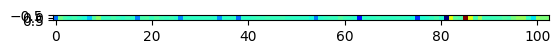

In [16]:
from matplotlib import pyplot as plt

plt.imshow(param_vals1[2].float().cpu(), cmap="jet")

print(tokenizer.decode(input_ids[0][param_vals1[2].float().topk(5).indices][0]))
print(param_vals1[2].float().topk(5))

In [19]:
for res in results:
    print("Q: ", res["example"]["question"])
    print("A (labels): ", res["example"]["answers"]["text"])
    print("LRP top5: ", res["lrp_top5_tokens"])
    print("LRP top5 attributions: ", res["lrp_top5_relevances"], '\n')

Q:  In what country is Normandy located?
A (labels):  ['France', 'France', 'France', 'France']
LRP top5:  France, region Norman country
LRP top5 attributions:  tensor([1.1452e-04, 4.3845e-05, 2.9287e-05, 1.8449e-05, 1.2439e-05]) 

Q:  When were the Normans in Normandy?
A (labels):  ['10th and 11th centuries', 'in the 10th and 11th centuries', '10th and 11th centuries', '10th and 11th centuries']
LRP top5:  10 first 10 people 11
LRP top5 attributions:  tensor([3.3029e-05, 2.2602e-05, 1.4791e-05, 1.1537e-05, 8.8099e-06]) 

Q:  From which countries did the Norse originate?
A (labels):  ['Denmark, Iceland and Norway', 'Denmark, Iceland and Norway', 'Denmark, Iceland and Norway', 'Denmark, Iceland and Norway']
LRP top5:  ers from raid,.
LRP top5 attributions:  tensor([5.3515e-05, 3.5023e-05, 8.7190e-06, 7.8946e-06, 6.2662e-06]) 

Q:  Who was the Norse leader?
A (labels):  ['Rollo', 'Rollo', 'Rollo', 'Rollo']
LRP top5:  Roll Iceland pirate leader,
LRP top5 attributions:  tensor([1.1889e-04, 